In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

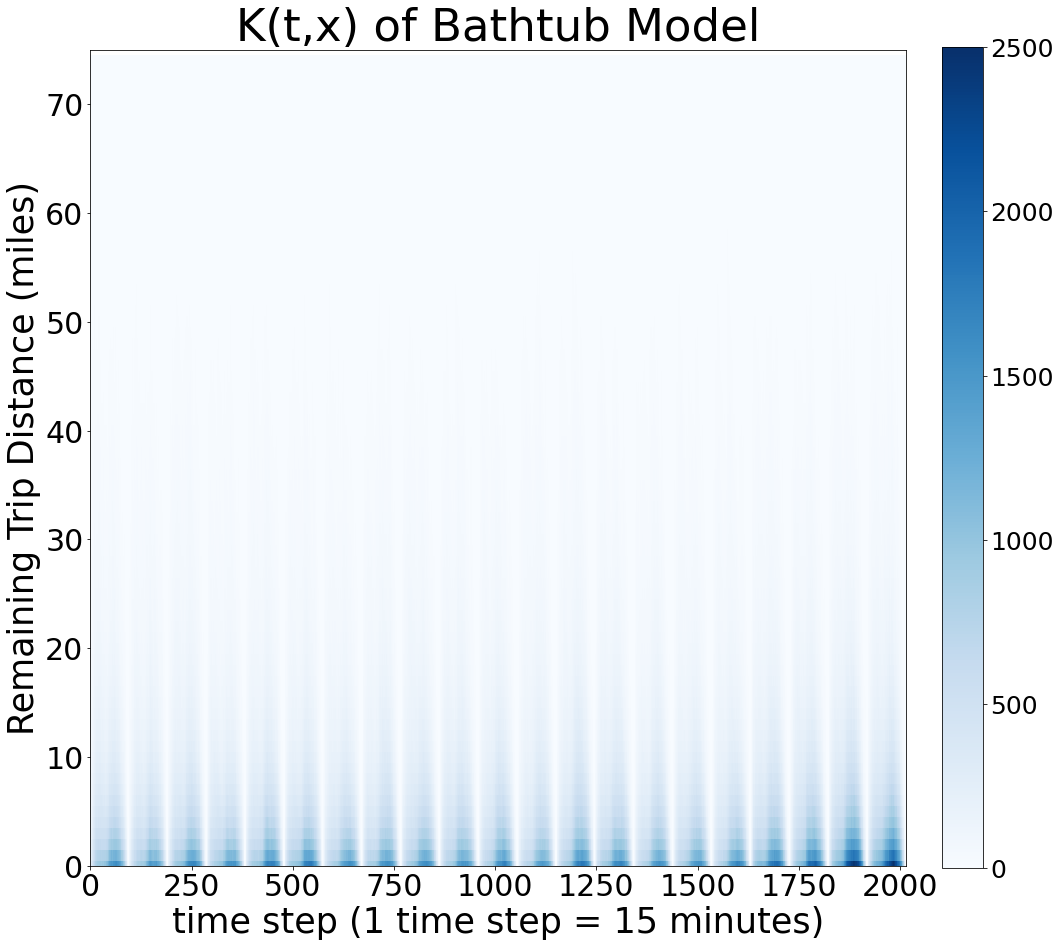

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.011167797574155151 0.011885184384480779 0.010450410763829524 0.8276752731082223
0.0065296692092314213 0.011473983029222817 0.0015853553892400253 0.8166629556347706
0.0058101796912369379 0.010827418269224325 0.00079294111324954963 0.7930052259542995
0.0057217224152515166 0.010679232841250021 0.00076421198925301131 0.7873140991935228
0.0055759568954917215 0.010452673343226707 0.00069924044775673572 0.7792451340509745
0.0053260137205817723 0.010094226544424078 0.00055780089673946611 0.7675290729356898
0.0051378095987909492 0.00985640442322443 0.00041921477435746888 0.761102781568357
0.005107247939727993 0.00981680604809913 0.00039768983135685668 0.7601992374995987
0.00510296360861945 0.0098135147900060074 0.00039241242723289389 0.7602256147479721
0.0050984959659907949 0.009809652141694384 0.00038733979028720623 0.760153311148987
0.0050894226026883633 0.0098031528234884518 0.00037569238188827524 0.7599588519168605
0.0050690157923973106 0.0097850185806426012 0.00035301300415202 0.75927630

0.0032230329406007512 0.0055558265156594611 0.000890239365542041 0.5768606651794713
0.0032224249053725853 0.0055495740304348359 0.00089527578031033431 0.5765449101020501
0.0032217068273531053 0.0055349002723456137 0.00090851338236059686 0.5758148057271106
0.0032213722359379169 0.0055258716184942757 0.00091687285338155834 0.5753488457410459
0.0032210123237557194 0.0055222371214801785 0.00091978752603126058 0.5751722399164629
0.00322042941657468 0.0055175192568642931 0.00092333957628506732 0.5749353844914253
0.0032191633216007414 0.0055177805550790148 0.00092054608812246793 0.5749370600383128
0.0032187049702754864 0.0055166229684864322 0.00092078697206454067 0.5748283045552609
0.0032184567903445504 0.0055187315942276409 0.00091818198646146027 0.574937003598413
0.0032183975020565608 0.0055178056128296089 0.00091898939128351312 0.5748810969120312
0.0032182592180601158 0.0055154072148412177 0.00092111122127901352 0.5747347889279659
0.0032181951678902495 0.0055160247996399831 0.0009203655361

0.0031730000216796659 0.005434092555759237 0.00091190748760009452 0.5697811736202449
0.0031729365106444255 0.0054331319895416664 0.00091274103174718421 0.5697252711212437
0.003172822553876512 0.0054334326606801332 0.00091221244707289121 0.5697378664608727
0.0031726950126328059 0.0054345512858346027 0.00091083873943100966 0.5697933688041286
0.0031726487477901962 0.0054347606569981723 0.00091053683858222025 0.5698209944953709
0.0031726370412536713 0.0054325096795882124 0.00091276440291913007 0.5697047748292946
0.0031726304967933504 0.00543176624179389 0.00091349475179281089 0.5696678557142374
0.0031726271069915518 0.0054315193388643317 0.000913734875118772 0.5696519943895643
0.0031726232843977448 0.0054310074685835338 0.00091423910021195555 0.569622713822153
0.0031726134727755114 0.005430715237607537 0.00091451170794348553 0.5696000181057564
0.0031725997318620084 0.0054299931739788818 0.00091520628974513544 0.569556794185214
0.0031725738889089757 0.00543001892182719 0.0009151288559907614

0.0031661411344577227 0.0054273451185902913 0.00090493715032515356 0.5693405357709141
0.0031659760378000205 0.0054287847157598107 0.00090316735984023071 0.5694242047951426
0.0031659428916761727 0.0054288280230948673 0.000903057760257478 0.5694282972342051
0.0031658213644734073 0.0054346303699294631 0.00089701235901735175 0.5697262069220239
0.0031657759931797451 0.0054326342476362531 0.00089891773872323747 0.5696083006172294
0.0031657494849318926 0.0054356500420501544 0.00089584892781363113 0.5697773542895092
0.0031657063171432903 0.0054341156102715726 0.00089729702401500767 0.5697057344480401
0.0031656841038121626 0.0054303134637689746 0.00090105474385535078 0.5694896934428171
0.0031656274474866145 0.0054336519088911493 0.00089760298608207955 0.5696819152192835
0.0031655888219124448 0.0054356914946981352 0.00089548614912675437 0.5697938131107143
0.0031655127983850066 0.0054350447706630759 0.00089598082610693752 0.5697571515250912
0.0031654626871049515 0.0054338172653583278 0.0008971081

0.003150008061859404 0.0053995817832902214 0.00090043434042858667 0.5676339004912258
0.003149903318933753 0.0053993637014517438 0.00090044293641576253 0.5676743596816527
0.0031497922132244392 0.005402188986456443 0.00089739543999243566 0.5677790630493367
0.0031497689361368732 0.0054012967732375589 0.00089824109903618738 0.5677181722028078
0.0031497162304316376 0.00540199288519658 0.00089743957566669539 0.5677746602621747
0.003149682762498321 0.005402586923581987 0.00089677860141465482 0.5678070057059026
0.0031496244669865811 0.0054035909938036433 0.00089565794016951852 0.5678626861093163
0.0031494553563193922 0.0054049785605749644 0.00089393215206382036 0.5679319997055985
0.0031493017018459973 0.00540583896818776 0.00089276443550423466 0.5679671904255834
0.0031489941118551111 0.0054050004698013975 0.00089298775390882494 0.5679037877995967
0.0031487450477876403 0.0054082908407435048 0.00088919925483177571 0.5680770935304347
0.0031486983437050845 0.0054084513401541833 0.00088894534725598

0.0031189756130464317 0.0053471905677606431 0.00089076065833222065 0.5650287059019985
0.0031178138610385916 0.0053341970182973182 0.00090143070377986473 0.5643379240963401
0.0031166712183353902 0.0053289083781475031 0.000904434058523277 0.5639928999434957
0.0031154684156643607 0.0053571826835462927 0.00087375414778242835 0.565488701199484
0.0031143093264409819 0.0053525068187526221 0.0008761118341293415 0.5651713815473304
0.0031136497267670485 0.0053405666281504394 0.00088673282538365779 0.5645360094544899
0.0031125999901535778 0.0053241340254578133 0.00090106595484934211 0.5636312095695641
0.0031119603247740011 0.0053301016554632491 0.00089381899408475288 0.5639743148030291
0.0031098528201624781 0.0053381568389943438 0.00088154880133061244 0.5644184933539639
0.0031091040743537945 0.0053293885532888505 0.0008888195954187383 0.5638489572581817
0.0031071088928611634 0.0053123742576890046 0.000901843528033322 0.563106647512096
0.0031054704235496506 0.0053054829028991429 0.0009054579442001

0.0030567314781344986 0.005258674358798991 0.00085478859747000586 0.5596740828464423
0.0030566582563297849 0.0052582328674409652 0.00085508364521860432 0.5596523512277105
0.0030566186887364716 0.0052586298797901217 0.00085460749768282156 0.5596787742032673
0.0030565333908347024 0.0052589367211118062 0.00085413006055759836 0.5597037003349388
0.003056349827454217 0.0052597289088299011 0.00085297074607853249 0.5597467676771561
0.0030561744130917687 0.0052625086761180677 0.00084984015006547 0.5598862139121034
0.0030559718342300815 0.0052647458884853273 0.00084719777997483553 0.5599774282702882
0.003055765056381248 0.00526306200935975 0.00084846810340274612 0.5598699282907812
0.0030556311675260972 0.0052679639721918943 0.0008432983628603 0.5601122323462288
0.0030555401046044842 0.0052638197604323372 0.00084726044877663127 0.5599084658346319
0.0030554679788312835 0.0052674886503822826 0.00084344730728028476 0.5601372451634782
0.0030553811390764134 0.00526749426969437 0.00084326800845845669 0

0.0030467241076615578 0.005230150072992947 0.00086329814233016889 0.5581908762979374
0.003046623855291016 0.0052304305725070369 0.00086281713807499522 0.5582048927131125
0.0030465366484292698 0.0052316131621746795 0.00086146013468386018 0.5582653439677714
0.0030464403361535582 0.0052306299142185052 0.00086225075808861137 0.5582359210350745
0.0030463409156234219 0.0052281428457932782 0.00086453898545356574 0.5581032378919459
0.0030462506277838365 0.00522811471714703 0.00086438653842064333 0.5581323608502011
0.0030461576088599224 0.0052242251480527791 0.00086809006966706537 0.5579166811934171
0.0030460722721574489 0.0052267738918199335 0.000865370652494964 0.5580358284559387
0.0030459797528590666 0.0052290969077209443 0.00086286259799718936 0.5581480586053836
0.0030458151989946388 0.0052282291994412752 0.00086340119854800244 0.5580943714226297
0.003045597931347648 0.0052256337895462837 0.00086556207314901262 0.5579580367158075
0.0030454865542880911 0.0052208847155106259 0.000870088393065

0.003036585947149928 0.0052175217459922854 0.00085565014830757077 0.5577082873162215
0.0030364999999809511 0.005215665127823974 0.00085733487213792813 0.5575934804177873
0.0030364322475793484 0.0052154698257035606 0.00085739466945513665 0.5575767219571865
0.0030363748466618826 0.0052154126262025195 0.00085733706712124585 0.5575722444756238
0.0030363113731047241 0.0052141288500561819 0.00085849389615326639 0.5575133455118438
0.003036279553543208 0.00521470209674128 0.0008578570103451366 0.5575483558308179
0.0030362382900963321 0.0052117251662705689 0.000860751413922095 0.5574035425102576
0.0030361900562032333 0.00521169027183885 0.00086068984056761669 0.5573934559336703
0.0030361297177675 0.0052117673415263393 0.0008604920940086608 0.5573944482781209
0.003036104087250734 0.0052145341072153753 0.00085767406728609239 0.5575380469826952
0.0030360603493725172 0.0052122067645006369 0.00085991393424439757 0.5574213476330947
0.0030360325639638848 0.0052122578758517025 0.00085980725207606757 0.

0.0030288415173223594 0.0051864416427937375 0.00087124139185098127 0.5563558193467886
0.0030288126270642374 0.0051869477124347326 0.00087067754169374209 0.5563788811917116
0.0030287717108334411 0.0051834998267812219 0.00087404359488566 0.5561975865437454
0.0030286932689721781 0.0051860452880573013 0.00087134124988705514 0.5563596580553624
0.0030285573626876137 0.0051803518033285258 0.00087676292204670212 0.5560703986290838
0.0030284442818906679 0.0051795939013246821 0.000877294662456654 0.5560222870482745
0.0030283712727445754 0.0051802201357871308 0.00087652240970202038 0.5560444850696126
0.0030283276055926203 0.0051789682582088744 0.00087768695297636614 0.5559750025854061
0.0030282813996105979 0.005183717495899136 0.00087284530332206031 0.5562388931946338
0.00302823905613743 0.005180882526232793 0.000875595586042067 0.5560959007171704
0.0030282096554426294 0.00517862088469767 0.00087779842618758853 0.5559806759041429
0.0030281330935227916 0.005179796646906612 0.00087646954013897115 0

0.0030229436160532524 0.0051763279642591331 0.00086955926784737156 0.5557754589666252
0.0030228526089070775 0.0051731900906731186 0.00087251512714103612 0.5556118900541479
0.0030228362485813839 0.0051744132505986695 0.00087125924656409866 0.5556756941121135
0.0030227159585155382 0.0051744169257430389 0.00087101499128803726 0.5556601031952094
0.0030226521576459634 0.0051680709231263118 0.00087723339216561514 0.5553427632903075
0.0030225877595833925 0.0051792620656090057 0.0008659134535577795 0.5559460373347097
0.00302252358080325 0.0051720240090846609 0.00087302315252183913 0.5555296466723921
0.0030224417304484095 0.0051712767429473172 0.00087360671794950212 0.5555019373269682
0.0030223539669845369 0.0051701059887219207 0.00087460194524715336 0.5554452897296012
0.003022302436767722 0.0051690652701888648 0.00087553960334657945 0.5553931429635021
0.0030222387613314567 0.0051657190410823034 0.00087875848158060958 0.5552249759034898
0.0030221540163319683 0.00516827704393784 0.00087603098872

0.0030149652657744997 0.0051556491058163383 0.000874281425732661 0.5545808036373013
0.0030148704150456578 0.0051539258072504056 0.00087581502284091032 0.5544820052661402
0.0030148289424995842 0.0051566578260369353 0.000873000058962233 0.5546279343734684
0.0030148034403116915 0.005152058755074033 0.00087754812554935023 0.5543830292303252
0.0030147938567273804 0.00515209454814616 0.000877493165308601 0.5543812348157537
0.0030147846938405978 0.00515678412889102 0.00087278525879017565 0.5546441284270118
0.003014729542150638 0.005157844266656472 0.00087161481764480434 0.5546885072155825
0.0030146952449253243 0.0051559196090815154 0.0008734708807691333 0.5545776425014521
0.0030146418380196135 0.0051535652717819127 0.00087571840425731409 0.5544609733041331
0.0030145584709854447 0.0051534284714817632 0.00087568847048912673 0.554461919296656
0.0030144401964240066 0.00515934711009798 0.000869533282750033 0.5547690211241603
0.0030143827154122875 0.0051583681174621728 0.000870397313362402 0.554702

0.0030099328976132124 0.00515144269474088 0.00086842310048554458 0.5542997778640093
0.0030098740365836012 0.0051497304463029112 0.000870017626864291 0.5542236100825342
0.0030098168541197244 0.0051470417268514035 0.00087259198138804508 0.5540736790936649
0.0030097833748739182 0.0051459787667345654 0.00087358798301327093 0.5540198444920863
0.0030097378549724103 0.0051462843875303517 0.0008731913224144693 0.5540286353101513
0.0030096983398134759 0.0051486209893197334 0.00087077569030721835 0.5541495974818952
0.0030096586256485886 0.005148150437333918 0.00087116681396325914 0.5541165522031223
0.003009604532005238 0.0051481530150623194 0.00087105604894815688 0.5541126541064634
0.0030095435609517936 0.0051476086272985644 0.0008714784946050227 0.5540818392232183
0.0030094684796570718 0.0051471825776742714 0.00087175438163987224 0.5540619137791709
0.0030093734706014867 0.0051469875177820338 0.00087175942342093942 0.554061300559036
0.0030093026052579442 0.0051474648035352835 0.00087114040698060

0.0030033077951379639 0.0051306523700546955 0.00087596322022123264 0.5531547014049002
0.0030032749453120489 0.0051284848332004357 0.00087806505742366243 0.5530467922388531
0.0030032380093654447 0.0051291439202811769 0.00087733209844971256 0.5530843083037746
0.0030031981056264489 0.0051297913520040863 0.00087660485924881111 0.5531166096140749
0.0030031490867551496 0.0051296175137433989 0.00087668065976690063 0.5531056591652933
0.0030031260333343189 0.0051302651056921895 0.00087598696097644787 0.5531405812796947
0.0030031113948618439 0.005132063777538865 0.0008741590121848226 0.5532417450322016
0.0030030962106962246 0.0051315326094302253 0.00087465981196222344 0.5532092996395341
0.0030030810389264752 0.00513274268638692 0.00087341939146603012 0.5532705914696053
0.003003060856407243 0.0051343507731743936 0.000871770939640092 0.5533498685054922
0.0030030333269220493 0.0051355580886804563 0.0008705085651636421 0.5534114414856602
0.0030030056784129213 0.0051374769766128082 0.0008685343802130

0.0029994935075847236 0.0051260436584648784 0.00087294335670456882 0.5529431030635034
0.0029994721080489764 0.0051260111050060158 0.00087293311109193676 0.5529410521196748
0.0029994505500356853 0.0051201602664278168 0.000878740833643554 0.5526365772580522
0.0029994303608828887 0.0051220213698132417 0.000876839351952536 0.5527356617837307
0.00299941006682647 0.0051220916208588423 0.000876728512794097 0.5527394569968814
0.002999395149653273 0.0051212605297822605 0.00087752976952428592 0.5526981084086581
0.0029993724893922669 0.0051207114868408871 0.0008780334919436468 0.5526725242035949
0.0029993367469450696 0.0051182596044839143 0.00088041388940622513 0.5525445912790166
0.0029992883644753983 0.0051173941109902933 0.00088118261796050308 0.5525008507062362
0.0029992240084829756 0.0051234685019056368 0.000874979515060314 0.5528263236531908
0.0029991600423287844 0.0051211482710877719 0.00087717181356979676 0.552707494759143
0.0029991081194538942 0.0051179879872766268 0.00088022825163116126 

0.0029938165810867463 0.005106745636341792 0.00088088752583170078 0.5518651164030166
0.002993769437813014 0.00510299731653517 0.00088454155909085768 0.5516808728296273
0.0029937349837386965 0.0051061783673711581 0.00088129160010623475 0.5518483317764106
0.0029937040675430812 0.005105981289021887 0.00088142684606427489 0.5518411081619593
0.0029936816219219911 0.0051061510986677413 0.00088121214517624064 0.5518548425455612
0.00299364305763834 0.0051096994931011473 0.00087758662217553274 0.5520493654481161
0.0029935967901696145 0.0051112643448198714 0.00087592923551935793 0.5521308864276281
0.0029935548090317212 0.0051129574937338017 0.000874152124329641 0.5522172811245215
0.0029934959655346345 0.005115157297480355 0.00087183463358891434 0.5523269960227475
0.0029934747764262153 0.0051115592498392759 0.0008753903030131548 0.5521241148511615
0.00299343923873994 0.0051119933509396623 0.00087488512654021727 0.5521471250853336
0.0029934044636063246 0.0051115749771001679 0.000875233950112481 0.

0.0029889368233248685 0.0050908905910711007 0.00088698305557863635 0.5511102021406958
0.0029888921149237285 0.00509030366259087 0.00088748056725658682 0.5510870640907207
0.0029888453381612776 0.0050884567315702175 0.00088923394475233758 0.5509781696338083
0.0029887793593470911 0.00508803704793471 0.000889521670759472 0.5509401688255053
0.0029887243572004714 0.00508607999771244 0.0008913687166885024 0.55082827579485
0.002988638796747265 0.0050872519893340766 0.00089002560416045378 0.5508856073822156
0.0029884997149782835 0.005090080154847975 0.00088691927510859163 0.551067171065321
0.0029883346482483934 0.0050914145990429817 0.00088525469745380481 0.551126945693073
0.0029881751174282473 0.0050906798282440158 0.00088567040661247879 0.5510848406012266
0.0029880978278338539 0.0050924391889846706 0.00088375646668303713 0.5511809833909752
0.0029879969267259917 0.0050892198825806534 0.00088677397087133 0.5510217106689097
0.0029879597086990332 0.0050897611471484461 0.00088615827024962038 0.551

0.0029839001720912287 0.0050848960995520092 0.00088290424463044806 0.5507500529384992
0.0029838129763786435 0.0050842885687334659 0.00088333738402382065 0.5507149614706796
0.0029837226594882763 0.0050833415044140877 0.00088410381456246524 0.5506743748137327
0.0029836708559261883 0.0050822265417220652 0.00088511517013031187 0.5506050901523258
0.002983615834309498 0.0050847710013504433 0.00088246066726855254 0.5507459855828059
0.0029835926408991091 0.0050827594030050287 0.0008844258787931899 0.5506515602525927
0.0029835506494416686 0.0050829943381238375 0.00088410696075949969 0.5506659951962866
0.0029835052453220635 0.0050824166394199252 0.00088459385122420173 0.5506341843442024
0.002983476112447717 0.0050826306109594075 0.00088432161393602656 0.5506331498528643
0.0029834242518374941 0.0050830064963401566 0.00088384200733483155 0.5506495402548399
0.0029833578461878076 0.0050822507481813458 0.00088446494419426927 0.5506138283670923
0.0029832922462014657 0.0050798972328046192 0.00088668725

0.0029794175358461494 0.0050778636190278951 0.00088097145266440339 0.5504295987393393
0.0029793828565193581 0.0050786500550919 0.00088011565794681574 0.5504757897159984
0.0029793574530299796 0.00508184782236829 0.00087686708369166886 0.550643913720598
0.0029793432416136529 0.0050798047512774077 0.00087888173194989813 0.5505398736655973
0.0029793273156836411 0.0050797004234679468 0.000878954207899335 0.5505330887821579
0.0029793064786320738 0.0050800593604472784 0.00087855359681686884 0.5505508283456391
0.0029792682784247292 0.0050798994066259184 0.0008786371502235397 0.5505436246620355
0.00297923310098002 0.0050800849583869595 0.00087838124357308067 0.5505544661511445
0.0029791866508081157 0.0050791974150391278 0.00087917588657710323 0.5505037810914566
0.0029791280217324081 0.0050793812875009744 0.00087887475596384185 0.550522136110435
0.0029790738403840788 0.0050774448370636957 0.00088070284370446222 0.5504186868602441
0.0029790297836703766 0.0050781501358294094 0.0008799094315113437 

0.0029736813767119539 0.0050720933734017233 0.00087526938002218454 0.5501843383263362
0.0029736338816003772 0.0050734098845926709 0.00087385787860808323 0.5502519654469155
0.0029736122008227461 0.00507107965813387 0.00087614474351162144 0.5501264938821195
0.0029735886528172257 0.0050732423501212041 0.00087393495551324777 0.550240833989317
0.0029735702123192191 0.0050716088125709559 0.00087553161206748223 0.5501595490818236
0.0029735364228436968 0.0050746079355520786 0.00087246491013531541 0.5503154422715241
0.0029735082849782555 0.0050727725291435169 0.00087424404081299408 0.5502108214106577
0.0029734796541593875 0.0050720025940815755 0.00087495671423719952 0.5501736699944982
0.0029734473011348811 0.0050709542303917013 0.00087594037187806054 0.5501183170910412
0.0029734363116521 0.0050718939759981088 0.000874978647306091 0.550171384138019
0.0029734019519450528 0.0050727844847224838 0.0008740194191676217 0.550221877605544
0.0029733334025019136 0.0050741918004808956 0.0008724750045229314

0.0029668085707390754 0.0050383701319091463 0.00089524700956900407 0.5483359100113981
0.0029666944017148395 0.0050252973692821107 0.00090809143414756867 0.5476011654597922
0.002966480426068801 0.0050332145947190494 0.0008997462574185525 0.5480349885415914
0.0029663294483154856 0.0050325784328297332 0.00090008046380123758 0.5479928951241692
0.0029662495793518723 0.0050302631191714671 0.00090223603953227768 0.5478784189809068
0.0029661802349774378 0.005030105766143135 0.00090225470381174045 0.547867840881673
0.0029660787693993056 0.0050232993145421755 0.00090885822425643538 0.5474890770865508
0.0029659096522565297 0.0050268433218462732 0.0009049759826667863 0.5476720540772194
0.002965690369823434 0.005021156855818232 0.000910223883828636 0.5473904933675281
0.0029655243359383481 0.0050190038035238613 0.00091204486835283483 0.5472595661851525
0.0029654139344649794 0.0050180664872376555 0.00091276138169230341 0.5472016222178577
0.002965276231262878 0.0050216719274323168 0.000908880535093439

0.0029556013245508675 0.0050211198861603744 0.0008900827629413602 0.5473444923147577
0.0029555300340484945 0.0050229817711184913 0.000888078296978498 0.5474462501319706
0.0029554153545111113 0.005023857826379337 0.0008869728826428853 0.5474977075787733
0.0029552908806096921 0.0050262617637086213 0.00088431999751076306 0.5476259138790531
0.0029551449089125206 0.0050256160355735763 0.00088467378225146488 0.5475901895952262
0.0029550116714388377 0.0050262920851150208 0.00088373125776265422 0.5476088242416922
0.0029549189955333645 0.0050252163688849763 0.00088462162218175288 0.5475440242701678
0.0029548713845238806 0.0050239889174123007 0.00088575385163546037 0.5474701158466437
0.0029548368701674569 0.0050264667956594154 0.00088320694467549873 0.5476203301623651
0.0029547874216342097 0.00502530247489356 0.00088427236837485966 0.5475565836247196
0.00295476128337634 0.0050250817506278722 0.00088444081612480815 0.5475428884582767
0.00295472506016369 0.0050257233676713987 0.0008837267526559816

0.0029494995610089107 0.0049979752574008038 0.00090102386461701734 0.5460935732593128
0.0029494311889106642 0.004998582468227283 0.0009002799095940453 0.5461264546065081
0.0029492953858958216 0.0049993177460637278 0.0008992730257279158 0.5461654644991923
0.0029492271728017131 0.004999717461710052 0.00089873688389337421 0.5461887511570775
0.0029490958555200364 0.0049997930919269814 0.00089839861911309132 0.546199059708841
0.002949011651582097 0.0050015231081764746 0.00089650019498771949 0.5462943738172855
0.0029489413546925393 0.0050009462603160188 0.00089693644906906024 0.5462699804431621
0.0029489250317195903 0.0049962945632663338 0.00090155550017284646 0.5460178329568692
0.0029488212775440207 0.0049966898492089535 0.00090095270587908826 0.5460474313070508
0.0029487860812977143 0.0049988759693641964 0.00089869619323123249 0.5461667217792521
0.0029487149231609317 0.0049985655997695508 0.00089886424655231251 0.5461544709075753
0.0029485652720994066 0.0049984020384270713 0.00089872850577

0.0029423038152184651 0.00499627862141926 0.00088832900901767049 0.546073645164911
0.002942195763123124 0.00499661117444348 0.00088778035180276792 0.546084983803732
0.0029421163910400032 0.004999052482731174 0.00088518029934883224 0.5462029427721034
0.0029420789831882724 0.0049988208469542083 0.00088533711942233632 0.5461930273842295
0.0029420410960304725 0.0049972083044122 0.00088687388764874546 0.5461057228159167
0.0029420040346285268 0.0049969090939406572 0.00088709897531639612 0.5460911397325566
0.002941922040051189 0.004996377568074699 0.00088746651202767921 0.546069222071267
0.0029418624666975876 0.0049968583898504469 0.00088686654354472858 0.546099893533007
0.0029418003781051397 0.0049962983647977143 0.00088730239141256476 0.5460934135640078
0.0029417481203746565 0.00499581900217052 0.00088767723857879259 0.5460709733125546
0.0029416799061789452 0.0049970450257472675 0.00088631478661062345 0.5461440517561398
0.0029416247240046309 0.004997242699214921 0.00088600674879434093 0.546

0.0029363731735058676 0.0049845129281736282 0.00088823341883810655 0.5454075136945706
0.0029363401397237434 0.0049834849065450819 0.0008891953729024052 0.5453593962066987
0.002936320197731213 0.004982179435251889 0.00089046096021053677 0.5452927892291185
0.0029363006652416705 0.004983730852079934 0.00088887047840340689 0.5453818559909183
0.0029362804513365461 0.0049828524545748936 0.00088970844809819843 0.5453301727154145
0.0029362533940815085 0.0049827461958485619 0.000889760592314455 0.5453195244927606
0.0029362299652304553 0.0049821083518849681 0.00089035157857594264 0.5452823405994042
0.0029362146750742742 0.0049836126821429612 0.000888816668005587 0.5453661806635295
0.0029361878535284309 0.0049829228241294356 0.00088945288292742648 0.5453266727449849
0.0029361577276157376 0.0049825241404436024 0.00088979131478787244 0.5453061080602171
0.0029361309986600495 0.0049836207828886135 0.00088864121443148539 0.5453702082893946
0.0029361140959908061 0.0049845052022323959 0.0008877229897492

0.0029319421979722609 0.0049773603830801493 0.00088652401286437273 0.5449784231176049
0.0029319289374364274 0.0049792292599196266 0.00088462861495322825 0.5450776596268923
0.0029319059662586784 0.0049767587939109304 0.00088705313860642588 0.5449391893723113
0.0029318875773218876 0.004975588027019669 0.00088818712762410619 0.5448843605683593
0.0029318578315432097 0.0049761688794764348 0.00088754678360998432 0.5449214473223576
0.0029318245631032233 0.0049762743905638973 0.00088737473564254917 0.5449260166436769
0.0029317928707527459 0.0049766140717144042 0.00088697166979108746 0.5449389764275182
0.002931750993276654 0.0049759161061820236 0.00088758588037128432 0.5449152400690411
0.0029317234847835013 0.0049739639759269682 0.00088948299364003411 0.5448069149433293
0.0029316981642255884 0.0049762901671432927 0.000887106161307884 0.5449339271058599
0.0029316529795038863 0.0049740016782157 0.00088930428079207215 0.5448034402596009
0.0029316193869841573 0.0049724915254159554 0.000890747248552

0.0029272139456625172 0.0049732492290739368 0.00088117866225109721 0.5447914346964928
0.0029271885947972308 0.0049705411097611275 0.0008838360798333341 0.5446388731967441
0.0029271666307414471 0.0049731849298390854 0.0008811483316438092 0.544781239768219
0.0029271403076471716 0.0049723496365006743 0.00088193097879366912 0.5447323902547846
0.0029271135199137686 0.0049703056847623705 0.00088392135506516626 0.5446306586439578
0.0029270857165849544 0.0049704655511866669 0.00088370588198324212 0.544635853359073
0.0029270506963315519 0.0049698770045491555 0.00088422438811394818 0.544600014114725
0.0029270237233318718 0.0049711433555842547 0.00088290409107948911 0.5446689465287082
0.0029269860805954083 0.0049706087982939054 0.000883363362896911 0.5446367914844188
0.0029269489271745 0.0049714986509958444 0.00088239920335315535 0.5446771573379067
0.0029269173007444374 0.00497195578170719 0.0008818788197816846 0.5446960310029888
0.002926898176643137 0.0049721286179556278 0.00088166773533064646 0

0.002921903514379382 0.0049507453865774405 0.00089306164218132342 0.5436193679310563
0.0029218379396084414 0.0049491093423920029 0.00089456653682488019 0.5435289736361537
0.0029217878680853266 0.0049504855126194357 0.00089309022355121739 0.5435971441411007
0.0029217562530023822 0.0049513151815728552 0.00089219732443190924 0.5436463152421681
0.002921696157449017 0.0049511405850599733 0.000892251729838061 0.5436403969141892
0.0029216702601262178 0.0049518937065927381 0.00089144681365969762 0.5436779768009393
0.0029216477538620339 0.0049525982174600768 0.00089069729026399077 0.5437142703946843
0.0029216110851361088 0.0049536854170767006 0.00088953675319551682 0.5437798128141246
0.0029215757088007725 0.0049545191497870336 0.00088863226781451166 0.5438259204395763
0.0029215261530875958 0.0049549649198028078 0.00088808738637238349 0.5438483810429449
0.0029214711034484288 0.0049544257637158459 0.00088851644318101164 0.5438233534625392
0.0029214168188705361 0.0049524281142863643 0.000890405523

0.0028789027598902441 0.0047757799439358348 0.00098202557584465351 0.5336701477202457
0.0028785600348180122 0.0047799285281112944 0.00097719154152472987 0.5339112921362943
0.0028782425525152025 0.0047770505789714477 0.00097943452605895763 0.5337702102725543
0.0028778894069349742 0.0047701281620901904 0.000985650651779758 0.5334059590269834
0.0028776695339305567 0.0047692920439189853 0.00098604702394212789 0.533384294852765
0.0028773545617494147 0.0047655536457780366 0.00098915547772079264 0.5331905413217772
0.0028767399373091449 0.0047620201003857705 0.00099145977423251955 0.5330077674508414
0.0028761416195539229 0.0047593902996757335 0.00099289293943211261 0.532860790089782
0.0028753837857813142 0.0047682945279230145 0.00098247304363961361 0.5333439246914913
0.0028744841343750745 0.0047788505992145932 0.00097011766953555563 0.5339205161545066
0.0028739154051629543 0.0047820170481591611 0.00096581376216674773 0.5340838527679969
0.0028730822190849215 0.0047764019466562807 0.000969762491

0.0028391266340530275 0.0047779818330603643 0.00090027143504569089 0.5336871506339673
0.0028387319582539004 0.004775462346627117 0.00090200156988068348 0.5335434644103104
0.0028383293430700451 0.0047766017816310482 0.00090005690450904209 0.533588069149351
0.0028378264811816448 0.0047709768327350915 0.00090467612962819846 0.5332563913674635
0.0028373487163929957 0.0047679667464931618 0.00090673068629282922 0.5331243997549878
0.002836792174324438 0.0047678732680670128 0.00090571108058186346 0.5331533116289014
0.0028364726019570797 0.0047703553310198942 0.00090258987289426552 0.5332498986450097
0.002835607682444335 0.0047521924531457047 0.00091902291174296479 0.5322634783009816
0.0028350579219587856 0.0047513733731134357 0.00091874247080413511 0.5321967232839873
0.0028343614619108235 0.004752051966574293 0.00091667095724735426 0.5321921243720478
0.0028340432442110425 0.004749372143713554 0.00091871434470853109 0.5320323548156869
0.0028335531351421678 0.0047398647138117041 0.00092724155647

0.0028094036134977533 0.0046816000992383538 0.00093720712775715242 0.5283285220253652
0.0028091780480456125 0.0046831499686010806 0.00093520612749014437 0.5284310403016592
0.0028086309669396645 0.0046818922030725805 0.00093536973080674891 0.5283687624559237
0.0028084246558759572 0.004672900201996775 0.00094394910975513914 0.5278478508855877
0.0028081198865072595 0.0046718846186316219 0.000944355154382897 0.527786107337281
0.0028078504046786077 0.0046783511372636829 0.00093734967209353206 0.5281206882122295
0.0028076206270249088 0.00467705859232415 0.000938182661725667 0.5280464081136002
0.002807430805506929 0.0046741301770086615 0.00094073143400519679 0.5278626962664131
0.0028073083136966712 0.0046748786036214639 0.0009397380237718782 0.5279111712952312
0.0028072133708698524 0.0046763533556424168 0.000938073386097288 0.5279968269114361
0.0028070922116444933 0.0046747933326616014 0.00093939109062738529 0.5279117290960975
0.0028068937902521493 0.0046728412538856855 0.00094094632661861292

0.0027934775828211385 0.0046483933825483036 0.00093856178309397343 0.5262929681713775
0.0027933306250572851 0.0046491807407358417 0.0009374805093787283 0.5263378916687854
0.0027931472633858645 0.0046510938306602136 0.00093520069611151507 0.5264390688178179
0.002792933499141414 0.0046522628659898119 0.00093360413229301637 0.5265001690186857
0.002792702702175178 0.0046542868695897445 0.00093111853476061143 0.5266026101415616
0.0027925520873999569 0.0046537747717528086 0.0009313294030471054 0.5265671162182163
0.0027924300251075413 0.0046550464953904582 0.00092981355482462454 0.5266418425023627
0.0027923825949545361 0.00465480210406159 0.00092996308584748235 0.5266309711536621
0.0027923005654699423 0.0046526130919343151 0.00093198803900556941 0.5265096618202455
0.0027921967590661119 0.0046529195535274844 0.00093147396460473966 0.526528333997223
0.0027920711416378574 0.0046539228832448909 0.00093021940003082382 0.5265829894417388
0.002791922278433541 0.00465421748279882 0.000929627074068262

0.0027779307310132144 0.0046247674519993122 0.00093109401002711655 0.5251183637662697
0.0027778500344407798 0.0046267760537913949 0.0009289240150901646 0.5252227907672751
0.0027776873039158413 0.0046245899719790868 0.00093078463585259609 0.5250994978514761
0.0027774150211003863 0.0046238612262278636 0.00093096881597290861 0.5250596253087265
0.0027772212328125777 0.00462864531813066 0.00092579714749449591 0.5253236745200267
0.0027770386878249276 0.0046280716044948518 0.00092600577115500306 0.5252892132364246
0.0027768815009745467 0.0046262869915942029 0.00092747601035489066 0.5251682640512922
0.0027767473170869071 0.0046268079299792786 0.00092668670419453539 0.5251870426392724
0.0027766591341189064 0.0046300290516362594 0.0009232892166015532 0.5253655923333906
0.0027765850975122052 0.0046308808356018676 0.00092228935942254269 0.5254210453361299
0.0027765070577653707 0.0046318420719382329 0.00092117204359250867 0.5254895530349257
0.002776387779985897 0.0046323324859147055 0.0009204430740

0.0027568844085651863 0.0046155711380845331 0.00089819767904583952 0.5245955796349123
0.0027566659146943877 0.0046105026308906867 0.00090282919849808869 0.5243216552193053
0.0027565289603006769 0.0046075066366258275 0.00090555128397552657 0.5241668576578484
0.0027564713857272721 0.0046053863288043678 0.000907556442650176 0.5240655897017369
0.0027563542872106076 0.0046045433146430373 0.00090816525977817808 0.5240057625588876
0.0027562730206830118 0.0046042456102862927 0.00090830043107973128 0.5239817035902848
0.0027561601754009838 0.0046034638423006176 0.00090885650850135028 0.5239349634494571
0.0027560151348670903 0.0046053378704061006 0.00090669239932808022 0.5240374563880301
0.0027558448439709668 0.0046023859203766157 0.0009093037675653176 0.5238819155176777
0.0027556025626563068 0.0046044861683710112 0.00090671895694160228 0.5240138498625565
0.0027553235038165133 0.0046082361641038832 0.00090241084352914364 0.5242305889257619
0.0027552314975137211 0.004609379957036217 0.000901083037

0.0027462683913104134 0.004611153328637525 0.00088138345398330149 0.5244333514053602
0.00274623949737776 0.004611526998875049 0.00088095199588047036 0.5244558242347604
0.0027461888321182893 0.0046126401820620958 0.00087973748217448264 0.5245202804112499
0.0027461443133093796 0.0046123860933037332 0.00087990253331502615 0.5244997979278507
0.0027460889937740646 0.0046133955802203407 0.0008787824073277884 0.5245534558855643
0.0027460310636669492 0.0046142564191988464 0.00087780570813505206 0.524590767234502
0.0027460097092974322 0.0046134870314255413 0.00087853238716932287 0.524546398601529
0.0027459512071674108 0.0046125688421081749 0.00087933357222664665 0.5245008471694625
0.00274586859107292 0.0046112145158355815 0.0008805226663102585 0.5244389422891677
0.0027458130114294153 0.004609013208367636 0.0008826128144911945 0.5243206284563301
0.0027457890684363848 0.0046108022243006429 0.00088077591257212679 0.5244474558533303
0.0027457020645259129 0.0046100978320451078 0.00088130629700671783

0.0027404991958327536 0.0046007172048520527 0.00088028118681345491 0.5239242855643786
0.0027404557615227868 0.0046017996847756053 0.00087911183826996822 0.5239864903070192
0.0027404222349575861 0.004603165588662657 0.00087767888125251487 0.5240642965906824
0.0027403853557193816 0.0046039456519978471 0.00087682505944091608 0.5241087803182302
0.0027403358219563285 0.0046042225081960163 0.00087644913571664068 0.5241241531816123
0.0027402921481757443 0.004604097071820557 0.0008764872245309314 0.5241201318331732
0.0027402433086270907 0.004604037890982236 0.000876448726271946 0.5241137877087338
0.0027402052546819954 0.0046044670695075595 0.00087594343985643156 0.524136889349816
0.0027401594538394064 0.0046052238171666766 0.00087509509051213609 0.5241782208017125
0.0027401175276652845 0.004606055526916562 0.00087417952841400721 0.5242238682088356
0.0027400743499545323 0.0046071251595734891 0.00087302354033557577 0.5242809858462789
0.0027400312198115218 0.0046069468439517286 0.0008731155956713

0.0027331060922403103 0.0045724771468521009 0.00089373503762852009 0.5222907718212811
0.0027330871257635319 0.0045733951055728153 0.00089277914595424859 0.5223397714327295
0.002733019858847531 0.0045723489772025961 0.00089369074049246622 0.5222806176980556
0.0027329542345970116 0.0045713543696289634 0.00089455409956506007 0.5222275209776387
0.0027328940277489755 0.0045700507020424164 0.00089573735345553455 0.522151666793712
0.00273280170406549 0.0045691302755479762 0.00089647313258300323 0.5220979219235393
0.002732719949926115 0.0045703876776272837 0.00089505222222494582 0.5221737059667646
0.00273270493435616 0.0045716369498556815 0.00089377291885663871 0.5222479850739525
0.0027326810038264667 0.0045725365845707064 0.00089282542308222722 0.5223051990273941
0.0027326054146296448 0.0045721202009515252 0.00089309062830776446 0.5222755459881884
0.0027325717371340791 0.0045745180111730933 0.00089062546309506439 0.5224026649910704
0.0027325405364319153 0.0045757333567265314 0.000889347716137

0.0027279708105110963 0.0045763914780768368 0.00087955014294535574 0.5225308824630336
0.00272784790609496 0.0045754590309707082 0.00088023678121921178 0.5224708243948012
0.0027276972156284754 0.0045737077137246443 0.00088168671753230691 0.5223795524035507
0.00272758662926143 0.0045741706781633994 0.000881002580359461 0.5224301210256819
0.0027275557139057184 0.0045734208863184031 0.00088169054149303365 0.5224023378352372
0.0027273929864063632 0.0045743458074353344 0.00088044016537739192 0.5224378802876968
0.002727260074471197 0.0045731501814373129 0.00088136996750508084 0.5223628354231232
0.0027271613318204072 0.0045718763711127351 0.00088244629252807918 0.5222967048279707
0.0027270586580794226 0.004569404021021 0.00088471329513784491 0.5221691263121429
0.0027270104834772333 0.0045700256617373525 0.00088399530521711444 0.5222047158831148
0.00272695264081806 0.0045701889673143087 0.00088371631432181152 0.5222095644661124
0.0027268632469723418 0.0045709368108997192 0.00088278968304496481 

0.0027204564378255688 0.0045640131241761368 0.00087689975147500028 0.5218828066964744
0.0027203994412739086 0.0045631428329492886 0.0008776560495985284 0.5218319780442289
0.0027203320219031449 0.0045611742235295051 0.00087948982027678433 0.5217178791790924
0.0027202988566814978 0.0045599877049040905 0.00088061000845890533 0.5216359347740069
0.002720135671703974 0.0045579510246305721 0.00088232031877737572 0.5215221550925805
0.0027200686380624279 0.00455796311259985 0.00088217416352500539 0.5215299648632873
0.0027199831265601812 0.0045579313326980526 0.00088203492042230984 0.521541773294729
0.0027198446916716712 0.0045579611131000165 0.00088172827024332612 0.5215432226874425
0.0027197628839449274 0.0045581790544668805 0.00088134671342297421 0.5215476037079158
0.002719712653718977 0.0045576599875520136 0.0008817653198859405 0.521516361071629
0.0027196534200685098 0.00455981173686088 0.00087949510327613959 0.5216385360470258
0.0027196123100446438 0.0045617320780916189 0.000877492541997668

0.0027135313122835683 0.0045529663199044158 0.000874096304662721 0.5211811679123086
0.0027135101309626055 0.0045521188723223038 0.00087490138960290688 0.5211366707140195
0.002713502063719518 0.0045510652609512484 0.00087593886648778738 0.5210807470858226
0.0027134898801421132 0.004551383404027878 0.00087559635625634861 0.5210945455134437
0.002713478528340476 0.0045514770690751492 0.0008754799876058031 0.5210965849611838
0.0027134687018676492 0.0045512153171367474 0.0008757220865985506 0.5210794376794557
0.0027134552710781968 0.0045510722118645448 0.000875838330291849 0.5210686063685428
0.0027134276866808333 0.0045503935501405258 0.00087646182322114049 0.5210293775359329
0.0027133943559297944 0.0045510372663541089 0.00087575144550547986 0.5210651587641635
0.0027133326145256432 0.0045513678034942535 0.00087529742555703322 0.5210874072656856
0.0027132962723944234 0.00455078175193996 0.000875810792848887 0.5210590668340819
0.0027132604691093827 0.0045512459234462368 0.00087527501477252913 

0.0027089923023057849 0.00454658926965793 0.00087139533495364031 0.5208530983456028
0.0027089344460233945 0.0045461203711398349 0.00087174852090695428 0.5208309986672018
0.0027088882754263354 0.0045459751953064748 0.00087180135554619606 0.5208247498491527
0.002708843874123984 0.0045459140228648123 0.00087177372538315594 0.5208208908041635
0.0027088056252025264 0.004545773177899606 0.00087183807250544674 0.5208126470886396
0.0027087611756603479 0.0045468240178357525 0.00087069833348494337 0.52087108853634
0.002708735246279599 0.0045492781493827661 0.0008681923431764322 0.5210004252839929
0.0027086781374112633 0.0045489771532122745 0.00086837912161025221 0.520980707032494
0.0027086533192574036 0.0045492780959384372 0.00086802854257636976 0.5209894339839288
0.0027086365286043989 0.004549129373631812 0.00086814368357698607 0.52097769182383
0.0027086128688514326 0.0045490959993942925 0.00086812973830857273 0.5209737606647791
0.0027085882584033665 0.004548118442179846 0.00086905807462688716 

0.0027007504589660423 0.0045338936946946653 0.00086760722323741884 0.5201253681260809
0.0027007228328059952 0.0045324894415065074 0.00086895622410548324 0.520050072308934
0.0027007004416646084 0.0045317180650628628 0.00086968281826635407 0.5200047386471907
0.002700659917662356 0.0045314331134575737 0.0008698867218671386 0.5199925281215934
0.0027006208885795129 0.0045313012368275955 0.00086994054033143013 0.5199909259159196
0.0027005722483233511 0.0045316192327897083 0.00086952526385699388 0.5200136179274233
0.0027005171852904392 0.004531971360552574 0.00086906301002830425 0.5200435925765038
0.002700487038924726 0.0045330580209903028 0.00086791605685914959 0.5201069712327845
0.002700450636243515 0.0045331649540360178 0.00086773631845101244 0.5201108557312107
0.0027004134595831849 0.0045328801889321637 0.0008679467302342063 0.520095699284336
0.0027003584930512794 0.0045329842661391328 0.00086773271996342608 0.5201037554987795
0.0027003032657148054 0.0045333618329528383 0.0008672446984767

0.00269431874207818 0.00450737731905486 0.00088126016510150032 0.5186280985882019
0.0026941902522251535 0.0045072411197050032 0.00088113938474530351 0.5186179587902359
0.0026940838245567266 0.0045079972743669542 0.00088017037474649924 0.5186616086731971
0.0026939680701566159 0.0045081951171283084 0.00087974102318492335 0.5186776252176555
0.002693924622636081 0.0045087696791904939 0.00087907956608166771 0.5187104842811212
0.0026938419586833586 0.0045094984139403254 0.0008781855034263918 0.5187480411062799
0.002693766015263676 0.0045095626724460944 0.00087796935808125761 0.5187512834584906
0.0026937153187967357 0.0045096193567027961 0.00087781128089067545 0.5187473532694801
0.0026936205265900588 0.0045088995318963926 0.00087834152128372488 0.5186959569396163
0.0026935510396521433 0.0045095151036814943 0.000877586975622792 0.5187164929849097
0.0026935007102676226 0.0045082016389110507 0.00087879978162419472 0.518643641317677
0.0026934563383805808 0.0045085148193443779 0.000878397857416784

0.0026879620517958097 0.0045121999211923053 0.000863724182399314 0.5188928719133006
0.0026879385212941732 0.0045114036304039788 0.0008644734121843673 0.5188494279224496
0.00268790251728725 0.0045102575967617825 0.00086554743781271776 0.5187896303811099
0.0026878657050184197 0.0045091766066411533 0.00086655480339568641 0.5187377997998032
0.00268783446015419 0.0045089516010782208 0.00086671731923015959 0.5187273702508106
0.0026878120568436027 0.0045089631999805316 0.0008666609137066738 0.5187297391389171
0.0026877792685071813 0.0045084944062023912 0.00086706413081197135 0.5187037124460826
0.0026877520366226431 0.0045082091530567183 0.00086729492018856815 0.5186873920206373
0.0026877101349969861 0.00450746672857173 0.00086795354142224252 0.5186417626644695
0.0026876613497787394 0.0045070095174899235 0.00086831318206755516 0.5186180056482869
0.0026876195898042892 0.00450640698189021 0.00086883219771836831 0.5185870063870945
0.0026875864328686546 0.0045062021850999735 0.00086897068063733593

0.0026830248994296705 0.0045046202670301462 0.00086142953182919433 0.518494173794004
0.00268284167998268 0.0045032482549345271 0.00086243510503083271 0.5184168583692355
0.0026827077198873241 0.0044986951758795267 0.00086672026389512133 0.518163152120927
0.0026826314815070417 0.0044980947662829661 0.00086716819673111694 0.5181292239333813
0.0026825264583121219 0.0044978326495066483 0.00086722026711759544 0.5181185505017019
0.0026824087816249721 0.0044968202758171229 0.00086799728743282127 0.5180613225461506
0.00268234866500635 0.0044950978057056367 0.00086959952430706378 0.5179666975563303
0.0026822678455063324 0.004494754403453669 0.00086978128755899606 0.5179470225201313
0.0026822153895992192 0.0044951465895253237 0.00086928418967311468 0.5179673306945344
0.0026821744027583322 0.00449668688250908 0.00086766192300758414 0.5180589809529721
0.0026821188550037629 0.004498625032133473 0.000865612677874053 0.5181792821126151
0.002682047769039823 0.0044978036277855448 0.0008662919102941011 0

0.0026758328836483051 0.004498429847270306 0.00085323592002630431 0.5183176505994893
0.0026757517108112767 0.0044992179604630995 0.00085228546115945409 0.5183596973005292
0.0026757167523246781 0.0044987187348856685 0.000852714769763688 0.5183286183938884
0.0026756449210182005 0.0044978234834404749 0.00085346635859592649 0.5182684573035324
0.0026755940467602336 0.0044977461101551579 0.00085344198336530924 0.5182613361351044
0.0026755154123338314 0.0044967531256551521 0.00085427769901251093 0.5181993128447773
0.0026754653727887089 0.0044957853854163919 0.0008551453601610263 0.5181370154466333
0.0026754479018108223 0.0044962864183829051 0.00085460938523873912 0.5181630749514952
0.0026753832170437566 0.0044970083327491132 0.00085375810133839962 0.5182049709920512
0.0026753479518326351 0.0044974584151387465 0.0008532374885265241 0.5182300951736158
0.0026752875331484465 0.0044980553617766693 0.00085251970452022389 0.5182584831915839
0.0026752452482692868 0.0044981627718597593 0.0008523277246

0.0026677902243639486 0.0044859894840194123 0.00084959096470848487 0.517527557649999
0.0026677550072811106 0.0044859951715356186 0.0008495148430266023 0.5175278873081529
0.0026676996327489118 0.0044851385695734844 0.00085026069592433935 0.5174825817659406
0.0026676426316653208 0.0044843127126466048 0.00085097255068403708 0.5174324880789585
0.0026675848260914329 0.00448386024061995 0.00085130941156291533 0.5174065900891482
0.002667552321884049 0.0044831545691616992 0.00085195007460639894 0.517368635079976
0.002667524833817245 0.0044826325344586452 0.00085241713317584487 0.517345320310492
0.0026675015793468028 0.0044828613120244708 0.00085214184666913449 0.5173592893160498
0.0026674722478025369 0.00448261075040915 0.00085233374519592389 0.5173442195700577
0.0026674492304463123 0.0044821976280579566 0.00085270083283466838 0.5173194649081376
0.00266743082664752 0.0044826608779477547 0.00085220077534728584 0.5173441449058102
0.0026673895608110118 0.0044819611117960711 0.00085281800982595231

0.0026624646756642843 0.0044790421984563242 0.0008458871528722443 0.5171122401738074
0.0026624369118037924 0.004478883481045891 0.00084599034256169366 0.517101431675911
0.0026624157493965331 0.0044788142135169 0.00084601728527616609 0.5170984440143028
0.002662370251277045 0.0044786341856252109 0.00084610631692887909 0.5170907161573801
0.0026623497390856226 0.0044792002797946779 0.00084549919837656755 0.517126076228594
0.0026623238130736356 0.004479232542089295 0.00084541508405797669 0.5171161562441554
0.0026622904280265737 0.0044795131613519128 0.00084506769470123438 0.5171356281686698
0.0026622762333008954 0.0044801931818793644 0.00084435928472242634 0.5171735148661099
0.0026622566624884356 0.004480908849376985 0.00084360447559988637 0.5172113332110229
0.0026622294066273059 0.0044816541443471565 0.00084280466890745585 0.5172515741254067
0.0026622083299611471 0.0044820483162202728 0.00084236834370202173 0.5172738328841822
0.0026621891359123397 0.0044821153347242024 0.000842262937100476

0.0026570100565691309 0.0044699258855937889 0.00084409422754447327 0.5167157630585287
0.0026569097620671263 0.0044714484026248764 0.0008423711215093762 0.5168010915826957
0.0026568307560212046 0.0044711181525925268 0.0008425433594498828 0.5167843473085463
0.0026567695883847513 0.0044709625138835019 0.00084257666288600069 0.516778006819375
0.00265668610414295 0.0044696672820032767 0.00084370492628262344 0.5167082660608036
0.0026566267906512593 0.0044696827256893532 0.00084357085561316536 0.5167125726624571
0.0026565585904516796 0.0044693175964305417 0.00084379958447281737 0.5166936483446161
0.0026565075420687664 0.0044708206605205587 0.00084219442361697407 0.5167828355832604
0.0026564311167721643 0.0044711050431315968 0.00084175719041273207 0.5167888553928545
0.0026564039703664689 0.0044706474773341743 0.00084216046339876348 0.5167545865217922
0.0026563750243861883 0.0044700683818712514 0.00084268166690112489 0.5167147123189778
0.0026563409963617046 0.0044695061247821575 0.0008431758679

0.0026520630811740342 0.0044594783926725232 0.00084464776967554511 0.5161076056832669
0.0026520181758518981 0.0044589728687345 0.00084506348296929581 0.5160819959566367
0.0026519937415951994 0.0044586925766380622 0.00084529490655233625 0.5160672320829841
0.0026519630891135462 0.0044584175368978657 0.00084550864132922684 0.5160531604264423
0.0026519365524529451 0.004458410899893882 0.0008454622050120083 0.5160545933353257
0.0026518844007184269 0.0044579705597265137 0.00084579824171034026 0.516028020927445
0.002651850817539797 0.0044578689354319249 0.000845832699647669 0.5160196453427225
0.0026518246048800784 0.0044573262352530282 0.00084632297450712847 0.5159933967332035
0.002651795277166078 0.0044581231174741385 0.00084546743685801735 0.5160368805987442
0.0026517490219479969 0.00445832281186102 0.00084517523203497358 0.5160486868002325
0.0026517099757610036 0.0044585919407390314 0.00084482801078297537 0.5160690612462434
0.0026516784104387865 0.0044579233812105318 0.0008454334396670412 

0.0026473433550550304 0.00444611232043191 0.00084857438967815156 0.5154289008106305
0.0026472171426924181 0.0044476926688455905 0.00084674161653924612 0.5155156326539506
0.0026470460046900532 0.004444852307864817 0.00084923970151528977 0.5153614754393289
0.0026468265526453927 0.0044430062833008491 0.000850646821989936 0.5152698962547745
0.0026466827122109296 0.0044456259884451893 0.00084773943597666972 0.5154137432120189
0.0026464770483811328 0.0044480253134919646 0.00084492878327030126 0.5155632628902751
0.0026463049653589524 0.0044474913689361113 0.00084511856178179389 0.5155317856676638
0.002646170256736326 0.00444936469508534 0.00084297581838731238 0.51562015511919
0.0026460436030231204 0.0044505931079695639 0.00084149409807667669 0.5156767772408782
0.0026459429344884932 0.0044524198848420286 0.00083946598413495806 0.5157771681114024
0.0026458536196718764 0.0044525048165996034 0.00083920242274414974 0.5157853151688158
0.0026457644368722429 0.0044507110017858774 0.000840817871958608

0.0026426032731293107 0.004442404500284193 0.00084280204597442817 0.5151721913764052
0.0026425913113422295 0.0044424072639627872 0.00084277535872167176 0.5151706744069373
0.0026425733734303323 0.0044430545486343238 0.000842092198226341 0.5152068862773939
0.0026425565907575409 0.0044438126792080042 0.00084130050230707778 0.5152485930456833
0.0026425331015047029 0.0044445516656364094 0.00084051453737299668 0.5152891647497381
0.0026424974002965617 0.00444525145230575 0.00083974334828737344 0.515322253581856
0.0026424854758763491 0.0044458174154710945 0.00083915353628160369 0.515352799432183
0.0026424515613804435 0.0044450330777944611 0.000839870044966426 0.5153106813261402
0.0026424218305624997 0.0044453311235943278 0.00083951253753067182 0.5153278054480892
0.0026423968974254222 0.0044448498326953795 0.00083994396215546522 0.5153034513788571
0.0026423728485591397 0.0044449678623358461 0.000839777834782433 0.5153168518747487
0.002642349779669967 0.0044452805740540094 0.00083941898528592466

0.0026389005217582035 0.00444105779882604 0.00083674324469036685 0.5151244240582342
0.0026388652967240041 0.00444132429482562 0.00083640629862238858 0.5151370382698335
0.0026388439587391216 0.0044406109315940938 0.00083707698588414935 0.515095106968754
0.002638822496653839 0.0044407082193737932 0.00083693677393388479 0.515101425799428
0.0026388076555306649 0.0044412340294485 0.00083638128161282982 0.5151320210890313
0.0026387949319653758 0.0044412410283500821 0.00083634883558066954 0.5151344705428889
0.0026387859987107823 0.00444085314766755 0.00083671884975401506 0.5151137125223275
0.002638770186669272 0.0044400627047055993 0.00083747766863294436 0.5150695797177793
0.0026387463355395909 0.0044406295484847591 0.00083686312259442308 0.5151009836592756
0.0026387229804627245 0.0044394453117744823 0.00083800064915096712 0.5150354713425558
0.0026386967127210157 0.0044385746045884295 0.00083881882085360207 0.5149863829774964
0.0026386631185577308 0.0044378724356217035 0.00083945380149375807 

0.0026342380900334752 0.00443103762652756 0.00083743855353938992 0.5146540063837026
0.002634229129953587 0.0044310435914568687 0.00083741466845030561 0.5146565967872763
0.0026342275946343772 0.0044303214321444939 0.00083813375712426066 0.5146106334234347
0.0026342082985765457 0.0044310330778178754 0.00083738351933521635 0.514653629211021
0.0026341986197715673 0.0044315992622441808 0.00083679797729895359 0.5146876685230392
0.0026341878061435036 0.004432219591136999 0.00083615602115000851 0.5147234540307473
0.0026341773562303435 0.0044323363857728454 0.00083601832668784215 0.5147316253982169
0.002634166385710388 0.0044322903042805489 0.00083604246714022684 0.5147285769524954
0.0026341553556124856 0.0044319151011289262 0.00083639561009604462 0.5147068770218223
0.0026341443737409945 0.0044316848266232733 0.00083660392085871534 0.514691712346522
0.0026341342068994336 0.0044316011777005282 0.00083666723609833883 0.5146848194110837
0.0026341251968010943 0.0044318267097668979 0.000836423683835

0.0026317503217563628 0.0044406136604289125 0.00082288698308381346 0.5152090644975472
0.002631739683510435 0.0044406375599211284 0.00082284180709974125 0.515211678703507
0.0026317091577751318 0.0044405480374170563 0.00082287027813320718 0.515205740486378
0.0026316927866447872 0.0044408384089678456 0.000822547164321729 0.5152209174196655
0.0026316613500126616 0.0044409630914954258 0.000822359608529897 0.5152238344646415
0.0026316369653723824 0.0044408462950192582 0.00082242763572550688 0.5152139112591924
0.0026316158849062953 0.0044414758773452983 0.00082175589246729264 0.5152427093444425
0.0026315812065779848 0.0044416835707167465 0.00082147884243922271 0.5152611123840022
0.0026315436401333015 0.0044417051725673621 0.00082138210769924075 0.5152645845887749
0.0026314792007774905 0.0044423377795016058 0.00082062062205337483 0.515300011471118
0.002631417002210935 0.0044426578799109471 0.0008201761245109231 0.5153141337536722
0.0026313781965144334 0.0044430592604339184 0.000819697132594948

0.002629240079540426 0.0044398753517341585 0.00081860480734669363 0.5151819882896614
0.0026292023088606321 0.0044388163113589377 0.000819588306362327 0.515117929245143
0.0026291710716778911 0.0044387013666914478 0.00081964077666433458 0.5150980246549689
0.0026291219028069111 0.0044373819501465316 0.00082086185546729053 0.515015664045689
0.0026290814054472002 0.0044371665261584235 0.00082099628473597725 0.5150119598836076
0.0026290623858038343 0.0044370273491405616 0.000821097422467107 0.5150032762513462
0.0026290370419455181 0.0044364945581063251 0.00082157952578471092 0.5149717343133953
0.0026290125950485157 0.0044359051132830431 0.00082212007681398841 0.5149407256033904
0.0026289993092297082 0.0044365291949984833 0.00082146942346093322 0.5149727531728474
0.0026289686672492604 0.0044370336089294207 0.00082090372556910013 0.5150046191777649
0.0026289373669197975 0.004438126480774845 0.00081974825306474974 0.5150665663418255
0.0026289093263924487 0.0044394240256165826 0.0008183946271683

0.0026262156147353419 0.00443279630170135 0.00081963492776933452 0.5147496832105134
0.002626143679029956 0.0044309132787262112 0.00082137407933370111 0.5146426020881911
0.0026260587555999725 0.0044298521295858956 0.000822265381614049 0.5145789494023478
0.0026260388859236121 0.0044301030079515443 0.00082197476389568006 0.5145790442933764
0.0026260057246838379 0.0044298391628002 0.00082217228656747594 0.5145633955749581
0.0026259316661534642 0.0044303597829851316 0.0008215035493217965 0.51459659921328
0.0026258721179567629 0.0044295864866865479 0.00082215774922697734 0.5145578503632972
0.0026258150197748121 0.0044296483786927434 0.0008219816608568811 0.5145591588637571
0.0026257614011459553 0.0044296444703689677 0.000821878331922943 0.51455826825927
0.0026257180637117433 0.0044289906012858916 0.0008224455261375955 0.514520743189073
0.0026256671258513 0.0044284576043876287 0.00082287664731497056 0.5144951105167358
0.0026256189842688931 0.0044266897962342792 0.00082454817230350667 0.514399

0.0026229852076213762 0.0044237745265409368 0.00082219588870181522 0.5142199870518402
0.0026229617602550603 0.0044238337693489173 0.00082208975116120325 0.5142207998439035
0.0026229503199274497 0.0044235148790830337 0.00082238576077186566 0.5142023714883994
0.0026229387362356762 0.0044229845398042122 0.00082289293266713979 0.5141705382802958
0.0026229276028693219 0.0044229815999265844 0.000822873605812059 0.514167024330308
0.002622919916535558 0.0044229544613258506 0.00082288537174526563 0.5141633260474987
0.0026229083033331817 0.0044235134064476087 0.00082230320021875491 0.5141922994056933
0.0026228958811259193 0.0044234757129180636 0.000822316049333775 0.514191272306559
0.0026228816631219541 0.00442330623290279 0.00082245709334111843 0.5141842742064205
0.0026228739658032767 0.0044229650439354925 0.00082278288767106121 0.5141668022125897
0.0026228649581519826 0.0044223302593596539 0.00082339965694431128 0.5141301199192957
0.002622860648938258 0.0044222555461980034 0.000823465751678512

0.0026208587670223139 0.0044173813546097814 0.00082433617943484649 0.5138404430519766
0.0026208422955422 0.0044179169128031135 0.0008237676782812867 0.5138693672196741
0.0026208239071668035 0.0044185979939969384 0.00082304982033666878 0.5139062827554369
0.0026208185523066826 0.004418341290411556 0.000823295814201809 0.5138943645802382
0.0026207764868066653 0.0044197712992426509 0.00082178167437067925 0.5139692972192571
0.0026207419650548223 0.004420158582823349 0.00082132534728629567 0.5139970454092082
0.0026207330009701169 0.004420411854709246 0.00082105414723098748 0.5140075266217259
0.0026206761789560411 0.0044190380980083177 0.00082231425990376484 0.5139317629949368
0.0026206371186699223 0.0044182154276214414 0.00082305880971840354 0.51388605964982
0.0026205905502003197 0.0044186893270785959 0.00082249177332204318 0.5139119021486169
0.0026205517333750187 0.0044187747407558164 0.00082232872599422079 0.513918248147869
0.0026204874782141431 0.0044183660946096751 0.00082260886181861133

0.0026177982789275691 0.0044175065244039923 0.00081809003345114631 0.5138536359317284
0.0026177651300339938 0.00441641793317116 0.00081911232689682752 0.5137920550486269
0.0026177255594120484 0.0044152733869524128 0.00082017773187168408 0.5137241727817602
0.002617696504344293 0.0044148087255915115 0.0008205842830970745 0.5136970152333263
0.0026176686592290352 0.0044154287658400033 0.00081990855261806659 0.5137303517206658
0.0026176488862260294 0.0044163257070031006 0.00081897206544895849 0.5137802552251236
0.0026176232142475372 0.0044167781226476929 0.00081846830584738142 0.5138040120046629
0.0026176008167149481 0.0044169250108428461 0.00081827662258705032 0.5138115608022152
0.0026175711700646511 0.0044158607371941406 0.00081928160293516137 0.5137529522272885
0.0026175606575740964 0.0044155856709077622 0.00081953564424043035 0.5137372948608645
0.002617529952165232 0.0044148343700247273 0.00082022553430573654 0.5136978321258256
0.0026174968843585195 0.0044139141980802559 0.0008210795706

0.0026150576857194344 0.004407670997612482 0.0008224443738263867 0.5133832478275657
0.0026149993299761855 0.0044069954274219914 0.00082300323253037949 0.5133461218061935
0.0026149325867264031 0.0044071601186119087 0.0008227050548408973 0.5133621484099395
0.0026148847358912256 0.0044100873016041106 0.00081968217017834035 0.5135312733098486
0.0026148354613491787 0.0044104842629415818 0.00081918665975677576 0.5135595053459747
0.0026147926002030491 0.0044105867959430773 0.00081899840446302127 0.5135656479665704
0.0026147455952281145 0.0044113507197070384 0.00081814047074919047 0.5136240414671938
0.0026147403281346834 0.0044114553067966522 0.000818025349472715 0.5136270440951182
0.0026146786324813278 0.0044115722460296514 0.00081778501893300416 0.5136301827862237
0.0026146310737161509 0.0044113062954435024 0.00081795585198879926 0.5136118454498725
0.0026145807661709813 0.0044120570439230254 0.00081710448841893683 0.513649339533084
0.002614549598994612 0.0044123346523658709 0.000816764545623

0.0026112567518789894 0.0044030347300333395 0.00081947877372463916 0.5131266842932207
0.0026112415207153409 0.0044039078453483463 0.0008185751960823359 0.5131753110161777
0.0026112247862716039 0.0044041901539123929 0.00081825941863081469 0.5131893007823072
0.0026112090912231716 0.0044042718279405785 0.000818146354505765 0.5131933868526093
0.00261118292426137 0.0044042910723561968 0.00081807477616654338 0.5131926375756437
0.0026111723808181966 0.0044051861492651438 0.00081715861237124921 0.5132456632222425
0.0026111325546458596 0.004404017991510488 0.000818247117781231 0.513173286368378
0.0026111266931415265 0.0044043126596508778 0.00081794072663217475 0.513191758447779
0.0026110874773328766 0.0044034361947017271 0.00081873875996402569 0.513138899513682
0.0026110542683769234 0.0044018502937817564 0.00082025824297209029 0.5130477368947459
0.0026110000266864278 0.0044013952291681669 0.00082060482420468872 0.5130221399935158
0.0026109251008249136 0.0044017626143150962 0.0008200875873347304

0.0026065562651820594 0.0043930888779643122 0.00082002365239980618 0.5125652329616567
0.0026065272931900824 0.0043932662533723906 0.00081978833300777446 0.5125802309901264
0.0026065130966247043 0.0043929594529570279 0.00082006674029238061 0.5125664622399337
0.0026064684873612631 0.004393248306789198 0.00081968866793332784 0.5125865402993215
0.0026064157652853463 0.0043932006111015789 0.00081963091946911327 0.5125924692038542
0.0026063742168342193 0.0043929830312842881 0.00081976540238415071 0.5125822886225004
0.0026063309645351874 0.004393363657129651 0.00081929827194072383 0.5126048631767443
0.002606259815454562 0.004394738339313131 0.000817781291595993 0.512684936357701
0.0026062112150403564 0.0043962329628821489 0.00081618946719856362 0.5127690952167903
0.002606141242543217 0.004398424376472595 0.00081385810861383926 0.5128900368218365
0.0026060977718173465 0.0043997990312477165 0.00081239651238697666 0.5129644404288598
0.002606074784360435 0.0043996859326543595 0.000812463636066510

0.0026033425813975744 0.0043965668127475682 0.000810118350047581 0.512862831625649
0.0026033125172776526 0.0043939277746817464 0.0008126972598735589 0.5127174303698555
0.0026032824849216629 0.0043944612565151734 0.00081210371332815273 0.5127491308784389
0.002603248861063898 0.00439505304534373 0.00081144467678406632 0.5127852038762329
0.0026032224324225172 0.0043950017990001282 0.000811443065844906 0.512785009131206
0.0026031909334587365 0.0043945469897944721 0.00081183487712300118 0.5127635656901253
0.0026031688540239166 0.0043945214409874386 0.00081181626706039445 0.5127642259070702
0.0026031629981498059 0.004394455411073004 0.00081187058522660754 0.5127601169225706
0.0026031525824176949 0.0043942895503214794 0.00081201561451391059 0.512748760327291
0.0026031281158835247 0.004393778518345914 0.00081247771342113514 0.5127168126203764
0.0026031063791270995 0.0043932925835495074 0.00081292017470469208 0.5126863586495357
0.002603085549024769 0.0043931078718369536 0.000813063226212584 0.5

0.0026004971573724157 0.0043870596055329 0.00081393470921193147 0.5122860498349148
0.0026004708616911808 0.0043871892774239385 0.000813752445958423 0.5122924848235204
0.0026004378680990845 0.00438646474327432 0.000814410992923849 0.5122516038756284
0.0026004054734397441 0.0043876617313903512 0.000813149215489137 0.5123190309983692
0.002600335229429433 0.0043872680449754215 0.00081340241388344419 0.512298126502018
0.0026002167495086819 0.0043864859809994534 0.00081394751801791023 0.5122541285817569
0.0026001843545541735 0.0043865938376281112 0.00081377487148023614 0.5122533387812671
0.002600125614929851 0.0043870631315703961 0.00081318809828930558 0.5122789545012376
0.0026000883291758775 0.0043864744585396173 0.00081370219981213778 0.5122441288418678
0.0026000391065589207 0.0043864146185808688 0.0008136635945369731 0.5122388094974483
0.0025999584407811046 0.0043866367632979025 0.00081328011826430644 0.5122478880283634
0.0025998892348042453 0.0043870701609462128 0.000812708308662278 0.51

0.0025975230329575946 0.0043857656547587531 0.00080928041115643572 0.512247487532996
0.0025975003856765658 0.0043853828659935591 0.00080961790535957257 0.5122215823739584
0.0025974666914720533 0.0043851250034101638 0.00080980837953394287 0.5122019726262531
0.0025974551522191355 0.0043859407163091566 0.00080896958812911419 0.5122457248951382
0.0025974363289938164 0.0043865077128461263 0.00080836494514150673 0.5122795359046894
0.0025974004555009062 0.00438637873128251 0.00080842217971930275 0.512270609832183
0.0025973613831244751 0.0043860566781260945 0.00080866608812285568 0.5122509996699075
0.0025973146565356 0.00438657768750927 0.00080805162556193055 0.5122841628820639
0.0025972437057039228 0.0043867935422252039 0.00080769386918264183 0.5123032616060766
0.0025972234549338689 0.0043861309207451583 0.00080831598912257951 0.5122645499738449
0.0025971946478691938 0.0043849602008612584 0.0008094290948771288 0.5121979444339302
0.00259714281456293 0.0043845462094080157 0.00080973941971784378

0.0025946981536865829 0.0043803920282099165 0.00080900427916324948 0.5119317387724736
0.0025946788279063997 0.0043809139257426312 0.00080844373007016854 0.5119585113628519
0.0025946637353649032 0.004381209082960631 0.000808118387769175 0.5119743226498726
0.0025946487992485993 0.004381731247474931 0.00080756635102226726 0.5120020666809754
0.0025946336547156912 0.004382105078185065 0.00080716223124631761 0.5120199052722847
0.0025946250041613216 0.0043825594185749319 0.000806690589747711 0.5120448149334137
0.0025946099981379433 0.0043817564282583286 0.00080746356801755781 0.511996584985987
0.0025945949337527864 0.0043810050821709665 0.00080818478533460679 0.5119523515951205
0.0025945764133895551 0.0043791338461813961 0.00081001898059771395 0.5118452174341381
0.0025945558539610882 0.0043778156717262165 0.00081129603619595962 0.5117705255350934
0.0025945404910843106 0.0043768784031271825 0.00081220257904143886 0.5117221648694417
0.0025945087624974425 0.0043759241993098063 0.0008130933256850

0.0025918378779335107 0.0043747289964321387 0.00080894675943488266 0.511597657293727
0.0025917914829653717 0.0043749380903599731 0.00080864487557077036 0.5116117551124849
0.0025917262225113647 0.0043761048333845389 0.00080734761163819022 0.511675914064792
0.0025916698331866612 0.004376525303324939 0.00080681436304838334 0.5117006285647214
0.0025916145250733085 0.00437739838746049 0.00080583066268612689 0.5117587932824175
0.0025915604103121082 0.0043765992974777275 0.00080652152314648884 0.5117213820591402
0.0025914986306080482 0.004374989165089869 0.00080800809612622735 0.5116384103556436
0.0025914418805319554 0.0043735836637387952 0.00080930009732511562 0.5115630388178019
0.0025914188368590238 0.0043734014924791181 0.00080943618123892954 0.5115523210975149
0.0025913739251508276 0.0043749660916255276 0.00080778175867612793 0.5116384551148728
0.002591353250237201 0.0043754251586261388 0.00080728134184826343 0.5116621680084614
0.0025913391883313703 0.0043756939530527443 0.000806984423609

0.0025891306474716842 0.0043687868900806719 0.00080947440486269623 0.5112391687641106
0.0025891228291821614 0.0043689529323069883 0.00080929272605733489 0.5112481030197381
0.0025891114763012969 0.0043691240646819649 0.0008090988879206288 0.5112587703532957
0.0025891034313023551 0.0043694335290897337 0.00080877333351497664 0.5112782344348872
0.0025890973532054825 0.0043691895667723026 0.00080900513963866262 0.5112668589708902
0.002589088363056683 0.00437001030928962 0.00080816641682374655 0.5113136020356505
0.0025890801592588575 0.004369861973606959 0.00080829834491075571 0.5113042965198717
0.0025890621986641668 0.0043697805300469969 0.0008083438672813368 0.5112983973765947
0.0025890528835323646 0.0043696385126018068 0.00080846725446292263 0.5112905484277711
0.0025890434622628119 0.0043700035073397691 0.00080808341718585468 0.5113111844754544
0.0025890357467291797 0.0043700421422744919 0.00080802935118386762 0.5113144878739275
0.0025890281610332576 0.0043702931555328929 0.00080776316653

0.0025871695080219837 0.0043665351197696633 0.00080780389627430375 0.5110782420798982
0.0025871527778306017 0.0043675292115810012 0.0008067763440802022 0.5111335337123659
0.0025871279228207684 0.0043668928882777255 0.00080736295736381122 0.5110943638226386
0.0025871008545226264 0.0043666231135025043 0.000807578595542749 0.5110777465915164
0.0025870948188378221 0.0043665391092772166 0.00080765052839842759 0.5110714193408175
0.0025870682153729045 0.0043666563745496309 0.0008074800561961782 0.5110786283608972
0.0025870329660449085 0.0043671244865049457 0.00080694144558487145 0.5111063302007052
0.0025869944428082679 0.00436756637040484 0.00080642251521169514 0.5111327113838698
0.0025869732610323149 0.0043674884159612733 0.00080645810610335627 0.5111265346154876
0.0025869299323814754 0.0043676203797365218 0.00080623948502642868 0.5111363136430184
0.0025869047705153509 0.0043676143111380846 0.00080619522989261721 0.511139368566788
0.0025868747090085006 0.0043673232484914568 0.000806426169525

0.0025850788228622685 0.0043642905749842215 0.00080586707074031567 0.5109482303535303
0.0025850712596101038 0.0043641168093060956 0.00080602570991411169 0.5109384136421002
0.0025850454515089129 0.0043642591700751012 0.000805831732942725 0.510943906411221
0.0025850208930189335 0.0043649985575594276 0.00080504322847843926 0.5109824573320727
0.0025849967027195843 0.0043655206710971478 0.00080447273434202109 0.5110130565661701
0.00258497346609104 0.0043655145991846455 0.0008044323329974342 0.5110144777317066
0.0025849429401232672 0.0043655689248627387 0.00080431695538379564 0.5110192296277059
0.0025849080051587726 0.0043653346902768654 0.00080448132004067973 0.5110040753320352
0.0025848767260291524 0.00436500312461518 0.00080475032744312439 0.5109808920130877
0.0025848372761152296 0.0043647966875516179 0.00080487786467884118 0.5109664808978691
0.0025847916624889638 0.0043634045356120794 0.00080617878936584835 0.5108773395988773
0.002584746850007499 0.0043634159062358336 0.00080607779377916

0.00258311234768934 0.0043628595264370061 0.00080336516894167348 0.5108813559302845
0.0025830938568183848 0.0043630329101485895 0.00080315480348817979 0.510894342826858
0.0025830662160093412 0.0043629061259640688 0.000803226306054614 0.5108889213687576
0.00258303841255818 0.0043626891911779566 0.00080338763393840342 0.5108797688141644
0.002583018119383983 0.0043623933365145012 0.00080364290225346446 0.5108621811574056
0.0025830066105933225 0.004362435239558122 0.000803577981628523 0.5108639391974129
0.0025829953751907949 0.0043623620913589237 0.00080362865902266589 0.510859660345252
0.0025829876252840152 0.0043624117793580712 0.000803563471209959 0.5108614671083218
0.0025829720455114264 0.0043627121327236 0.00080323195829925327 0.510876936634347
0.0025829562306572593 0.0043625528754391652 0.00080335958587535313 0.5108659988561274
0.0025829375327257615 0.0043623351375593105 0.00080353992789221243 0.5108560165837036
0.0025829053493321265 0.0043618839363542168 0.00080392676231003633 0.510

0.0025815607031709938 0.0043580026417376775 0.00080511876460431027 0.5106294844411483
0.0025815504299904 0.0043578965362841534 0.0008052043236966461 0.5106261265872319
0.002581542338397841 0.0043572974823852442 0.000805787194410438 0.5105916171933517
0.0025815347366225962 0.0043570853203309277 0.000805984152914265 0.510578145030932
0.0025815296634012727 0.0043563628013796023 0.00080669652542294265 0.510536741099865
0.0025815209214507966 0.00435674648174357 0.00080629536115802336 0.510558887569237
0.0025815139011166354 0.0043569637860467409 0.00080606401618653009 0.5105728407297847
0.00258151089471053 0.0043566732288325746 0.00080634856058848527 0.5105563025175863
0.0025815090793428314 0.0043566016959404649 0.00080641646274519818 0.5105533636793961
0.002581502353653588 0.0043567507946068338 0.000806253912700342 0.510563901911571
0.0025814919417989448 0.00435660578115822 0.00080637810243966955 0.5105561315242116
0.0025814840355718261 0.0043564293812143147 0.0008065386899293376 0.51055048

0.0025800566880324113 0.004355957561326505 0.00080415581473831758 0.510521967834528
0.0025800288238852706 0.0043570418048969554 0.00080301584287358594 0.5105763185286675
0.0025800147650951785 0.0043571140768510217 0.00080291545333933544 0.5105802119977005
0.0025799884566514351 0.0043575080472726159 0.00080246886603025432 0.5105996373944396
0.0025799650253967321 0.0043578405291375029 0.000802089521655961 0.510612453429997
0.0025799484904463635 0.0043580263715094188 0.00080187060938330835 0.5106191243108085
0.0025799268887349734 0.0043582616068438291 0.00080159217062611746 0.5106307784879855
0.00257988929874323 0.0043582607710402005 0.000801517826446259 0.510631199519637
0.0025798308137545307 0.0043582965041850524 0.00080136512332400938 0.5106380082852032
0.0025797922267915227 0.0043578951694846144 0.00080168928409843061 0.5106274643503577
0.0025797800446299246 0.0043573962668507632 0.000802163822409086 0.5106042965354036
0.0025797634632138576 0.0043571016395234459 0.00080242528690426885

0.0025788518352475834 0.0043569111039409355 0.00080079256655423152 0.5105944892724867
0.002578846671602 0.0043569704966065085 0.00080072284659749146 0.5105961856159886
0.0025788422497326265 0.0043566266222816313 0.00080105787718362184 0.5105767664117155
0.0025788275509378241 0.0043569402441398144 0.00080071485773583375 0.5105960494438047
0.0025788191410998449 0.0043573599980392874 0.0008002782841604021 0.5106196353818219
0.0025788107984463411 0.00435782074870988 0.00079980084818280213 0.5106471995399539
0.0025787987549712958 0.0043583509836773266 0.00079924652626526464 0.5106797096369207
0.0025787848667488946 0.0043587113965520086 0.0007988583369457809 0.5107017423893788
0.0025787721485312177 0.0043592727806458058 0.00079827151641663008 0.5107355001830414
0.0025787580397728274 0.0043594900572303521 0.00079802602231530278 0.5107470351833099
0.0025787464626154297 0.00435986933013903 0.00079762359509182891 0.5107658291811858
0.0025787380347817544 0.0043596716854324424 0.000797804384131066

0.0025776993934797468 0.0043482371182740794 0.000807161668685414 0.5101408129727432
0.0025776843456005987 0.0043494794398986287 0.00080588925130256855 0.5102087271406583
0.0025776811668888262 0.0043505772024847655 0.00080478513129288664 0.5102673538552349
0.002577659155079336 0.004350717443264227 0.00080460086689444462 0.5102752089424065
0.0025776472263436137 0.0043505094425993641 0.00080478501008786341 0.5102644357877204
0.002577635047266397 0.0043502515521183548 0.00080501854241443889 0.5102516125351633
0.0025776219268214121 0.0043504452198042864 0.00080479863383853755 0.5102631085697044
0.002577605358910379 0.0043505798111624526 0.000804630906658305 0.5102717380433985
0.0025775938518880111 0.0043506049357255961 0.0008045827680504264 0.5102725961418704
0.0025775685433385423 0.0043512253653980627 0.00080391172127902146 0.5103123340675173
0.0025775516427530231 0.004350660604076689 0.00080444268142935754 0.5102797589882362
0.0025775290274600649 0.0043493845125410907 0.000805673542379039

0.0025766697121588893 0.0043494183447116749 0.00080392107960610413 0.5102088236558902
0.0025766629373597835 0.0043494807097983782 0.00080384516492118877 0.5102110588676539
0.0025766552582622503 0.004349747394845024 0.00080356312167947691 0.5102237689309826
0.0025766449142542412 0.0043500339551496535 0.00080325587335882884 0.5102389892491002
0.0025766257093044805 0.0043507483630235459 0.00080250305558541527 0.5102769863237847
0.0025766158980960311 0.0043511064308730365 0.00080212536531902546 0.510291128622493
0.0025765895552896183 0.00435233932791767 0.00080083978266156665 0.5103597356322447
0.0025765687215703469 0.0043522813771514814 0.00080085606598921232 0.5103578638368615
0.0025765552387956034 0.0043522962171761558 0.00080081426041505145 0.5103587311196871
0.0025765392032884868 0.0043520302269998258 0.00080104817957714781 0.5103412957470432
0.0025765267441312583 0.0043516871447298608 0.00080136634353265629 0.51032008279661
0.0025765114484197992 0.0043515215198468944 0.00080150137699

0.0025749825536897949 0.0043511479261333667 0.00079881718124622306 0.5103184911572922
0.0025749738810454149 0.0043514768281988844 0.00079847093389194578 0.5103377881271949
0.0025749652249976813 0.00435143614001526 0.0007984943099801022 0.510334793481835
0.0025749564614278423 0.0043513459084848468 0.00079856701437083821 0.5103279213823935
0.0025749451567151911 0.0043512471276224481 0.00079864318580793374 0.510320345123792
0.0025749316989881208 0.004351371236782065 0.0007984921611941761 0.5103240130946259
0.0025749193157742403 0.0043514666390811474 0.00079837199246733323 0.5103278186552833
0.002574908850523173 0.0043518848586587208 0.00079793284238762494 0.5103502232453708
0.0025748992737859707 0.0043519162738087864 0.00079788227376315524 0.5103520473701261
0.0025748878113814508 0.00435190819729914 0.000797867425463761 0.5103523332223104
0.002574872223111859 0.0043519155643790249 0.000797828881844693 0.5103509604088899
0.00257485903584676 0.0043511448986279615 0.00079857317306555875 0.51

0.0025736667302788071 0.0043531203699681857 0.00079421309058942875 0.5104263601635742
0.0025736540142103598 0.00435236663604529 0.0007949413923754291 0.5103854593253692
0.0025736007652756737 0.0043528408396185572 0.00079436069093279029 0.5104107254175176
0.0025735795011530343 0.0043525849812454855 0.00079457402106058344 0.5103972699902453
0.0025735635549256138 0.0043519893009185059 0.0007951378089327216 0.510364725935099
0.0025735501530717996 0.0043515020050474019 0.00079559830109619735 0.5103369208837
0.0025735398819865347 0.0043512511356970235 0.000795828628276046 0.5103231734335689
0.002573518063108445 0.004350753209668214 0.00079628291654867641 0.5102951882733482
0.0025735007858996707 0.0043496815376516083 0.00079732003414773294 0.5102296043624751
0.0025734839567729275 0.0043502905364084417 0.000796677377137413 0.5102626167239339
0.0025734669342280039 0.0043509813939792575 0.00079595247447675026 0.5102988499412137
0.0025734560669601865 0.0043518343993665248 0.00079507773455384824 0

0.0025721048724225842 0.0043466667915217092 0.0007975429533234595 0.5100713025305761
0.0025720851683080129 0.0043467671665221213 0.00079740317009390491 0.5100820246097963
0.0025720650325090472 0.0043465346305224242 0.00079759543449567046 0.5100692283181922
0.0025720416522304222 0.0043457303632369916 0.00079835294122385266 0.5100236834934104
0.0025720282397055645 0.0043461421517760231 0.00079791432763510561 0.5100505110450334
0.0025720154212577704 0.0043463756966554638 0.00079765514586007747 0.510065776447694
0.002571999459333008 0.0043466721476764234 0.00079732677098959227 0.5100844475450959
0.0025719760737183909 0.00434657955457795 0.00079737259285883122 0.5100808191723057
0.00257195936123865 0.0043464290514420665 0.00079748967103523342 0.510073942098077
0.0025719473376791145 0.0043464263350929278 0.00079746834026530125 0.5100736042733912
0.0025719213135531266 0.0043460952157703707 0.00079774741133588247 0.5100550123309121
0.0025718968052781434 0.0043454856266134543 0.0007983079839428

0.0025703429260842021 0.0043414990496764595 0.0007991868024919452 0.5098205406922218
0.0025703264253565533 0.0043412736538892254 0.00079937919682388143 0.509804450782041
0.0025703058943985562 0.0043412613965121624 0.00079935039228495 0.509800452877622
0.0025702950850140681 0.0043405323434359475 0.000800057826592189 0.5097549768736367
0.002570275305398858 0.0043411376525176338 0.00079941295828008213 0.5097858165376699
0.0025702594962766626 0.0043409696531924976 0.00079954933936082762 0.5097750789796758
0.0025702431926774719 0.00434071291015044 0.00079977347520450372 0.5097593352859778
0.0025702376242947465 0.004340670227363389 0.00079980502122610389 0.5097516311664618
0.0025702210607904678 0.0043405149087839805 0.000799927212796955 0.5097403482447392
0.0025701993196268636 0.0043407833714279621 0.00079961526782576487 0.5097528119257086
0.002570157247731917 0.0043411604251731807 0.00079915407029065345 0.5097651397955817
0.002570132209413161 0.00434158094579636 0.00079868347302996243 0.509

0.0025689557583765616 0.004339789960382678 0.00079812155637044532 0.5097158289183356
0.0025689494081814358 0.0043399127009863883 0.00079798611537648342 0.5097219559380317
0.0025689416572308326 0.004340307813257783 0.00079757550120388256 0.5097438063967168
0.0025689290681278837 0.0043406469957082538 0.00079721114054751366 0.509760504332957
0.0025689191555667013 0.0043410191139239013 0.000796819197209501 0.5097805526931314
0.0025689044603909505 0.0043421213560534966 0.00079568756472840445 0.5098424903950363
0.0025688898148752736 0.0043424439753756072 0.00079533565437494007 0.5098578776562172
0.0025688809823864876 0.0043429872333207685 0.00079477473145220712 0.5098930392746519
0.0025688613107425844 0.004343820957183513 0.00079390166430165564 0.5099382248851954
0.0025688374721703315 0.00434452831387359 0.0007931466304670734 0.509972565599716
0.0025688169424919129 0.004345516993803495 0.00079211689118033086 0.5100236861509224
0.0025688024168139777 0.0043469366189085477 0.0007906682147194072

0.0025675897091260638 0.0043465350691351823 0.00078864434911694566 0.5100473674356526
0.002567578431568982 0.0043459947247771712 0.0007891621383607927 0.5100142905498191
0.0025675662164801449 0.0043452642612782756 0.00078986817168201419 0.5099708641107676
0.002567552025454777 0.004344606880563236 0.00079049717034631846 0.5099329332903288
0.0025675356476669089 0.0043445221272924587 0.000790549168041359 0.5099277508651687
0.00256752032759135 0.004344199992992898 0.00079084066218980257 0.509910162384464
0.0025675072527193868 0.004344123701496878 0.00079089080394189519 0.5099085481834572
0.0025674905540124943 0.0043423501660086721 0.00079263094201631641 0.509810276489574
0.0025674687760719075 0.0043426816210973863 0.00079225593104642893 0.5098290899029785
0.0025674521667390119 0.004343133681779251 0.00079177065169877276 0.5098543315114544
0.0025674383839311586 0.0043430791899230362 0.00079179757793928118 0.5098492156300424
0.0025674286534854529 0.0043432242905691604 0.00079163301640174522 

0.00256613663772905 0.0043389917976054352 0.0007932814778526644 0.5096161894215301
0.0025661314568521561 0.00433981511803457 0.00079244779566974173 0.5096612166412787
0.0025661219793615942 0.0043398430923376726 0.00079240086638551613 0.509663397876775
0.0025661083810165136 0.0043395290108672194 0.00079268775116580733 0.5096449294520832
0.0025661022622181389 0.0043399160938034061 0.00079228843063287185 0.5096635851348429
0.0025660960440038109 0.0043398162308011107 0.00079237585720651107 0.5096558559828059
0.002566092207775629 0.0043396904838048991 0.00079249393174635847 0.5096470274384353
0.0025660887787239631 0.0043397587507141133 0.00079241880673381259 0.5096495368017313
0.002566079667454172 0.0043401650440150789 0.00079199429089326539 0.5096715471044289
0.0025660705921480564 0.0043404478815561249 0.00079169330273998846 0.5096842229597783
0.0025660532437328607 0.00434063938767801 0.00079146709978771121 0.5096942750983676
0.0025660127368168084 0.0043411822462333851 0.000790843227400231

0.002564379827148295 0.00434409878311611 0.00078466087118047949 0.5098718506352882
0.0025643620438940452 0.0043435149810200418 0.00078520910676804908 0.5098357816899888
0.0025643420677251313 0.0043435741153196681 0.00078511002013059467 0.5098375109364384
0.002564325450485079 0.0043436684024744853 0.00078498249849567317 0.509843396882414
0.0025643110355633271 0.0043441723065249759 0.000784449764601678 0.5098698957778676
0.0025642991719075693 0.0043439356642566611 0.00078466267955847719 0.5098593751196503
0.0025642881653955008 0.0043433714292081937 0.00078520490158280739 0.5098261015313965
0.0025642714258902822 0.0043430672814180754 0.00078547557036248857 0.509811378762688
0.0025642567226940929 0.0043431529545605212 0.00078536049082766457 0.5098187632231558
0.002564237891736135 0.00434317333953053 0.00078530244394174023 0.5098208189560128
0.0025641997696192018 0.0043426927657129006 0.00078570677352550271 0.5097930877646248
0.0025641886105600953 0.0043431429896522069 0.0007852342314679838

0.0025620902521867181 0.0043374824031218034 0.00078669810125163268 0.5095331476968055
0.0025620687099270883 0.0043379160671794407 0.00078622135267473548 0.509558309641896
0.0025620467989861872 0.0043379349524176585 0.00078615864555471625 0.50955981227689
0.0025620278075604826 0.0043382323315825184 0.0007858232835384469 0.5095760854463659
0.0025620114029184667 0.0043379319917265825 0.00078609081411035121 0.5095575035676838
0.0025619985762663912 0.0043371388428405542 0.00078685830969222844 0.5095103577797144
0.0025619878050567 0.0043363365716502606 0.0007876390384631396 0.5094636107759913
0.002561981848857614 0.0043360765701658636 0.00078788712754936465 0.5094451450059094
0.0025619660907370105 0.0043347828301565266 0.0007891493513174949 0.5093708227471067
0.0025619433224139854 0.0043351230890437487 0.00078876355578422241 0.509391031875652
0.0025619112372574273 0.0043358330736919448 0.00078798940082290992 0.5094326322543706
0.0025618848898893167 0.0043364934671211572 0.0007872763126574764

0.0025599823529697582 0.00433307257682868 0.00078689212911083625 0.5093404957103984
0.0025599684662966607 0.0043332724647830905 0.00078666446781023062 0.5093493786023375
0.0025599524023436093 0.0043338307030687407 0.00078607410161847806 0.509378584937013
0.0025599379587550042 0.004333649530222642 0.00078622638728736624 0.5093661635575975
0.0025599211083897578 0.0043336010633513158 0.00078624115342820029 0.5093637859110145
0.0025599020953831174 0.0043336064799338351 0.00078619771083239976 0.5093666036566347
0.0025598743916261991 0.0043336392046808281 0.00078610957857157 0.5093735209865526
0.0025598422888895478 0.0043341573539554621 0.00078552722382363351 0.5094023882974997
0.002559808650684994 0.0043342422739773272 0.00078537502739266024 0.5094091991960187
0.0025597850399313887 0.0043352650730224089 0.00078430500684036834 0.509467569748115
0.002559736341447042 0.00433494002277388 0.00078453266012020427 0.5094443178203953
0.002559702947766699 0.0043344170461798318 0.0007849888493535658 0

0.0025574373214098129 0.0043357468130024437 0.00077912782981718178 0.509476817121549
0.00255742506019825 0.0043355348629018709 0.00077931525749462885 0.5094585167844696
0.0025574042853450255 0.0043352546902418595 0.00077955388044819124 0.5094422274845162
0.0025573632844537071 0.004334926107558818 0.00077980046134859668 0.5094267136717701
0.0025573208833751279 0.0043340824192575752 0.00078055934749268069 0.5093783294675642
0.0025572827635320424 0.0043324934278026733 0.00078207209926141178 0.5092896331859388
0.0025572490113100923 0.0043330140490903729 0.000781483973529812 0.5093193532217597
0.0025572247629783084 0.004333676388373878 0.00078077313758273916 0.5093540553004379
0.0025572057681112043 0.0043337133906864549 0.00078069814553595387 0.5093526010025414
0.002557176179065342 0.0043337136681394885 0.00078063868999119575 0.5093499778738019
0.0025571451166692513 0.0043342400396584576 0.00078005019368004489 0.5093773575363447
0.0025571175577601473 0.0043346174071848794 0.0007796177083354

0.0025550628104223688 0.0043247571922540038 0.00078536842859073359 0.5088824139221787
0.0025550268096809917 0.0043248326744388665 0.00078522094492311718 0.5088905425184782
0.0025550006003940144 0.0043252019409400341 0.00078479925984799445 0.5089144786906008
0.0025549204146857732 0.0043253162072533925 0.00078452462211815429 0.5089201066453398
0.0025548496213360517 0.0043267125268953415 0.00078298671577676159 0.5089906120806419
0.0025547787273889123 0.0043271101144458863 0.000782447340331938 0.5090036794567613
0.002554743484020358 0.0043283041371441483 0.00078118283089656764 0.5090582973761905
0.0025547294778853103 0.00432832782674514 0.00078113112902548009 0.5090539732590185
0.002554709921506242 0.0043287137675134717 0.00078070607549901247 0.5090781044679998
0.0025546932735190293 0.0043284546577423465 0.000780931889295712 0.5090648842086006
0.0025546804250041375 0.0043286194818081668 0.00078074136820010793 0.5090725123659605
0.0025546553670924991 0.0043288843066051136 0.0007804264275798

0.00255241292928363 0.004325934950575201 0.00077889090799205933 0.5089435323382187
0.0025524012771826776 0.0043259138465786369 0.000778888707786718 0.5089407403396768
0.0025523968981500155 0.0043252355384694238 0.000779558257830607 0.5089006324752056
0.0025523825959573375 0.0043252066651584126 0.00077955852675626216 0.508898112968163
0.00255237024902779 0.0043251240082300873 0.00077961648982549289 0.5088939801352639
0.0025523483405197832 0.00432444126408576 0.00078025541695380621 0.5088561480524643
0.0025523269967174843 0.0043237718519547217 0.000780882141480247 0.5088151362090888
0.0025523058986133837 0.0043230234604398309 0.00078158833678693628 0.5087714483257032
0.002552288158965381 0.00432285482128456 0.00078172149664620146 0.5087551932683837
0.0025522660445873634 0.0043229008852857034 0.00078163120388902326 0.5087541182179653
0.002552255267114157 0.0043227901747063336 0.00078172035952198051 0.5087487130643565
0.0025522224066796681 0.00432287376608192 0.00078157104727741668 0.50875

0.0025476981738192035 0.0043203982613397272 0.00077499808629868 0.5086005108673921
0.0025476739825616283 0.0043206505075982235 0.00077469745752503324 0.5086177849036743
0.0025476488832251276 0.0043206300359425022 0.00077466773050775307 0.5086173832079669
0.0025476154133226522 0.0043206782588334543 0.00077455256781185035 0.5086225314379352
0.0025475931107374304 0.0043202783648743793 0.00077490785660048122 0.5086020708953157
0.0025475665285566748 0.0043198579118572042 0.00077527514525614573 0.5085771418587929
0.0025475437066414027 0.0043192145278354637 0.000775872885447342 0.5085406243313719
0.0025475260429765438 0.004319552625090691 0.00077549946086239645 0.5085582823265526
0.0025475107562487895 0.0043192461547451669 0.00077577535775241225 0.5085386509027179
0.0025474979897053855 0.0043214925328452954 0.00077350344656547539 0.508664017144167
0.0025474840948159754 0.0043213698110418008 0.00077359837859015035 0.5086572193669555
0.002547460340317209 0.0043212558341687041 0.0007736648464657

0.002543092827905262 0.0043161222270575719 0.000770063428752952 0.5084049650337916
0.0025430416130343327 0.004316521544533246 0.00076956168153541923 0.5084269965350695
0.0025429936772224716 0.0043166172954611157 0.00076937005898382728 0.5084268423076068
0.0025429522295786836 0.004317056764349448 0.00076884769480791934 0.5084456045287741
0.0025429186670818363 0.0043175481201658686 0.00076828921399780376 0.5084653274745811
0.0025428743354217417 0.004316751569918292 0.000768997100925191 0.5084189248152682
0.0025428200410345667 0.004316534100251508 0.00076910598181762575 0.5084066207485494
0.0025427758133582793 0.0043169162611675447 0.00076863536554901374 0.5084284970727019
0.0025427413333397649 0.0043176943373525916 0.0007677883293269387 0.5084714345373134
0.0025427091700640182 0.0043187334056535593 0.00076668493447447686 0.5085317659416793
0.00254268221091939 0.0043198837680533848 0.00076548065378539531 0.5085962282782244
0.0025426396651365389 0.0043192327175329281 0.00076604661274014979

0.002538899063495045 0.0042963722001049679 0.00078142592688512245 0.5074112498085489
0.0025388370105072374 0.0042955112857473244 0.0007821627352671501 0.5073604708868859
0.0025387957203951554 0.0042945291369721212 0.00078306230381818942 0.5073038332634026
0.0025387593413603074 0.0042939362053056335 0.00078358247741498158 0.5072605105574912
0.0025387291895425227 0.0042938745770095188 0.00078358380207552635 0.5072625501853077
0.0025387050714776741 0.0042937674695616929 0.00078364267339365537 0.507254877265875
0.002538668274994574 0.004294187897089209 0.00078314865289993887 0.5072768647635285
0.0025386421800443031 0.0042943945605529539 0.00078288979953565192 0.507290837909131
0.0025386185687254707 0.0042956146647586671 0.00078162247269227393 0.5073550942536641
0.00253859268858826 0.0042953187741417379 0.00078186660303478149 0.5073412958099093
0.0025385676221161618 0.0042952157667273385 0.000781919477504985 0.5073348955298076
0.0025385356017928362 0.0042946828426458881 0.000782388360939784

0.0025349908381285874 0.0042869430000518852 0.000783038676205289 0.5068969288828449
0.0025349285059286649 0.0042875321032184253 0.00078232490863890418 0.5069332824355396
0.0025348458147838476 0.0042888172034999108 0.00078087442606778422 0.5070107051040531
0.0025347535515970326 0.0042908683397930763 0.00077863876340098924 0.507120822061463
0.0025346737341443047 0.00429027256710587 0.00077907490118273915 0.5070863549217045
0.002534566353437945 0.0042890614658512112 0.00078007124102467908 0.5070155257491521
0.0025345226373248548 0.0042869868693103993 0.00078205840533931048 0.5068992244973433
0.0025343978339981083 0.0042856717531482881 0.00078312391484792847 0.5068246149335296
0.0025343446099144185 0.0042846777946060031 0.00078401142522283409 0.5067726932756149
0.0025343164118581912 0.0042841036118463167 0.00078452921187006593 0.5067435960160349
0.002534303016750874 0.004283560020650579 0.00078504601285116942 0.5067129248466783
0.0025342941392959444 0.00428371721167644 0.000784871066915449

0.002531278291296569 0.0042744287657092549 0.00078812781688388292 0.5061593157076488
0.0025312418106683741 0.0042739705783619453 0.00078851304297480277 0.5061381526377887
0.0025312170692785951 0.004274286244185208 0.000788147894371982 0.506156586269862
0.0025311942270666602 0.0042751412405319621 0.00078724721360135821 0.5062042846510083
0.0025311724531857931 0.0042759401900472043 0.00078640471632438163 0.5062472899790518
0.0025311593003762333 0.0042755890744377951 0.00078672952631467176 0.5062264746153328
0.002531132284397455 0.0042760770776475963 0.0007861874911473134 0.50625218211751
0.0025311003036429707 0.0042759021143489321 0.00078629849293700973 0.5062402740833857
0.002531071423787337 0.0042754839537179987 0.000786658893856675 0.5062164490071049
0.0025310336548118252 0.004274769118881693 0.00078729819074195725 0.5061760939343997
0.0025309895254676733 0.0042749703695133985 0.0007870086814219479 0.5061896018738653
0.0025309431011297859 0.004275867846708201 0.00078601835555137034 0.

0.0025282123449694893 0.004276776997942486 0.0007796476919964924 0.5062915694453303
0.0025281962794923064 0.0042761307649875711 0.000780261793997042 0.5062519184784577
0.0025281666033558953 0.0042757249902839094 0.00078060821642788139 0.5062309229910326
0.0025281333878623886 0.0042759472458012166 0.00078031952992356046 0.5062426687029995
0.0025280890569041974 0.0042756545913340462 0.00078052352247434881 0.5062249839030925
0.0025280412719748614 0.0042762242801323925 0.00077985826381733064 0.5062499424052617
0.0025280010107411066 0.0042757761902770869 0.00078022583120512638 0.5062207826051792
0.00252794859699059 0.0042757056643198616 0.00078019152966131845 0.5062112149189512
0.0025278781528450768 0.0042759170973724614 0.00077983920831769182 0.5062156624714226
0.0025278109602732812 0.0042763391628484349 0.00077928275769812707 0.5062386472813096
0.0025277744396041604 0.0042782095238586377 0.00077733935534968332 0.5063429857320427
0.0025276991641238703 0.0042766568159888184 0.00077874151225

0.0025254930737071057 0.00427175111968969 0.00077923502772452068 0.5059516796205099
0.002525463352081943 0.00427206523720209 0.00077886146696179567 0.505968636615251
0.0025254017418708066 0.0042717304952339368 0.00077907298850767622 0.5059456412273029
0.0025253612844626733 0.0042714344626551019 0.00077928810627024483 0.5059314031810287
0.0025253328180213355 0.0042713375696457993 0.00077932806639687208 0.5059283712899514
0.0025253061674283014 0.0042714933005927281 0.0007791190342638745 0.5059390717564426
0.0025252751365550472 0.0042717852619360893 0.00077876501117400514 0.5059556439374673
0.002525238404093169 0.00427241199618051 0.00077806481200582854 0.5059883020537094
0.0025252081120378253 0.0042727736496226383 0.00077764257445301266 0.5060039001543646
0.0025251795569646521 0.0042733717405468337 0.00077698737338247059 0.5060327078118178
0.0025251528634888856 0.0042735153933886752 0.0007767903335890962 0.5060380466446288
0.0025251284022450348 0.0042731886479741342 0.0007770681565159350

0.00252219411812218 0.0042845489981330536 0.0007598392381113065 0.5065791477022783
0.0025221778575155842 0.0042841758895411711 0.00076017982548999715 0.5065553466404566
0.0025221614877741394 0.0042845919240273441 0.00075973105152093436 0.5065755373374021
0.0025221366413882623 0.0042854493444353867 0.00075882393834113835 0.5066179269722189
0.00252212439292621 0.0042868503191543922 0.00075739846669802739 0.5066873556671119
0.0025221050777657879 0.0042868093698701908 0.00075740078566138478 0.5066846816196773
0.002522057365509864 0.0042866313378868131 0.000757483393132915 0.5066779623388926
0.0025220118204515125 0.0042860683733074454 0.00075795526759558007 0.5066481081203225
0.002521944789721898 0.0042857779970610719 0.00075811158238272452 0.5066319937456215
0.0025219165754761883 0.0042835810578205884 0.00076025209313178809 0.5065078452566204
0.0025218477265708549 0.0042835193639035171 0.00076017608923819289 0.5064978300961802
0.0025217717034895313 0.0042842610229558188 0.00075928238402324

0.002517991821131335 0.0042711855571185321 0.00076479808514413774 0.5057775675762124
0.0025179628938578761 0.0042712692127362976 0.00076465657497945441 0.5057801512236033
0.0025179401222640827 0.0042709946217913113 0.00076488562273685414 0.505760455991814
0.0025179183085057692 0.0042706969349090868 0.00076513968210245142 0.5057385196408632
0.0025178887023556903 0.0042701392754169627 0.00076563812929441807 0.5057014018622231
0.0025178558641261008 0.0042699203722904606 0.000765791355961741 0.5056877819922434
0.0025178350489780451 0.0042699846240918833 0.00076568547386420709 0.505686520476013
0.0025177847357715985 0.00426940851573535 0.00076616095580784747 0.5056591537252936
0.0025177523726897513 0.0042693455161740878 0.00076615922920541526 0.5056597575502542
0.0025177173076571424 0.0042704085513506906 0.00076502606396359454 0.5057238981927052
0.0025176898339339055 0.0042708876355769115 0.00076449203229089963 0.5057493001894241
0.0025176699426631742 0.0042711024822812823 0.000764237403045

0.0025150039014665217 0.0042641638143419763 0.00076584398859106686 0.5054513524359147
0.0025149914822804984 0.0042633848807685591 0.00076659808379243789 0.5054078523241854
0.0025149810474809822 0.004263099620100185 0.00076686247486177977 0.5053912605443961
0.0025149710634677705 0.004262848142674882 0.00076709398426065935 0.505376532553913
0.0025149569550699438 0.0042626908156366706 0.0007672230945032166 0.5053665858560091
0.0025149369910988616 0.0042619682748361665 0.0007679057073615562 0.5053272249395163
0.0025149143330826227 0.0042609773128798661 0.000768851353285379 0.505271527193755
0.0025148933872304558 0.0042606106461178 0.0007691761283431125 0.5052508748003464
0.002514859468279341 0.0042599635776976444 0.0007697553588610379 0.5052104117239432
0.0025148091681949846 0.0042600921592121071 0.0007695261771778622 0.5052121539608189
0.0025147165103834661 0.0042613834327583054 0.00076804958800862706 0.505280260227438
0.0025146528919024113 0.0042619043322832534 0.000767401451521569 0.505

0.0025100522517208178 0.0042567872463833119 0.00076331725705832375 0.5050273358278544
0.0025099459644712624 0.0042557833990688907 0.00076410852987363412 0.504979381953572
0.0025098435003064194 0.0042516159407533054 0.0007680710598595334 0.5047463355714529
0.0025097370861759008 0.0042516543703565481 0.00076781980199525329 0.5047514895012202
0.0025096880113218952 0.0042520027818825383 0.00076737324076125188 0.5047747463483295
0.0025096313489802028 0.0042511975697088009 0.00076806512825160461 0.504730368818958
0.0025096021200129363 0.0042511314547274337 0.00076807278529843887 0.5047258026731758
0.0025095709288754271 0.0042496733173874078 0.000769468540363446 0.5046432130641167
0.0025095381369890585 0.0042505342305146849 0.00076854204346343217 0.504690343403351
0.00250949172399005 0.0042519868098582709 0.00076699663812182918 0.5047619024599044
0.0025094286275941014 0.0042529685235187624 0.00076588873166944025 0.5048103695081861
0.0025093520817865748 0.0042536897116408337 0.0007650144519323

0.0025029660808304917 0.0042529000818447909 0.00075303207981619255 0.5048223175185953
0.0025028543662428703 0.0042526014980356144 0.00075310723445012613 0.5048015811583886
0.0025027816340355887 0.004252845240085147 0.00075271802798603069 0.504818538646107
0.0025026802153681267 0.0042547946071979578 0.00075056582353829552 0.5049313501308477
0.0025025555810401553 0.0042565066165400336 0.00074860454554027739 0.5050198796696019
0.0025024130057881848 0.0042577207633946405 0.00074710524818172883 0.5050883724969522
0.0025022402411073916 0.0042598989106628227 0.00074458157155196051 0.5052087879607207
0.0025021032071912987 0.0042606733683594683 0.000743533046023129 0.5052549941432335
0.002501975902944428 0.0042607734152970622 0.00074317839059179355 0.5052662677140916
0.0025018574036797078 0.00426125633355136 0.000742458473808056 0.5052989925621696
0.0025017669361320012 0.0042604667298624718 0.00074306714240153049 0.505250863797883
0.00250167196285321 0.0042605588912588517 0.0007427850344475681 

0.0024934220392990604 0.0042415701791118088 0.00074527389948631222 0.5041121187078288
0.0024933107708709702 0.0042414837861814237 0.00074513775556051714 0.5041087585134658
0.0024931840543058669 0.0042408964653107353 0.00074547164330099889 0.5040770903014836
0.0024931269560624775 0.004240563763170938 0.000745690148954017 0.5040515697568072
0.002493059091613784 0.004241571306044311 0.00074454687718325714 0.5041088226284127
0.0024927974021501354 0.0042430252682376293 0.00074256953606264121 0.5041815324320078
0.0024926407518174086 0.004243320901594955 0.00074196060203986214 0.5041965032687039
0.0024925101218113309 0.0042442153172742641 0.0007408049263483978 0.5042472499183511
0.0024923993347859847 0.0042443070267640095 0.00074049164280795944 0.5042531840663771
0.0024922861347872831 0.0042450330512684856 0.00073953921830608056 0.5042935670393324
0.0024921353023891744 0.0042457855089604044 0.00073848509581794471 0.5043462092828719
0.0024920201066569291 0.0042453285753700021 0.000738711637943

0.0024836647829711263 0.0042672594112423568 0.00070007015469989537 0.5056313885531037
0.0024835844002580034 0.0042660284411405484 0.00070114035937545881 0.5055506623444465
0.0024835172332842181 0.0042655746817247707 0.00070145978484366552 0.5055242992101483
0.0024834513135831861 0.0042662643776289035 0.00070063824953746888 0.5055604647600193
0.0024833938259451504 0.004265774128646707 0.00070101352324359418 0.5055326077179144
0.0024833327531529237 0.0042651112461725756 0.000701554260133272 0.5054919255890711
0.0024832797246101888 0.0042655205002455282 0.00070103894897484962 0.5055135984914958
0.002483224799736609 0.004264734091494987 0.00070171550797823066 0.5054724074459443
0.002483168892348593 0.0042633220080734915 0.00070301577662369448 0.5053945657307362
0.0024830971929413375 0.0042619882192506892 0.00070420616663198574 0.5053238642830814
0.0024830143296569484 0.0042603228461361529 0.00070570581317774416 0.5052384264029154
0.0024829446056173561 0.0042584008341093188 0.00070748837712

0.0024630282573956169 0.0042966084464280078 0.00062944806836322633 0.5075369327559515
0.0024627261136144782 0.0042958307680733589 0.00062962145915559725 0.5075004799094402
0.0024624702704016703 0.004296902874433634 0.00062803766636970629 0.5075600242597872
0.002462069128959059 0.0042937045408774459 0.00063043371704067251 0.5073590914593898
0.0024615596492076819 0.0042918023942048588 0.00063131690421050523 0.5072321457782956
0.0024612082735546987 0.004293386700937994 0.0006290298461714037 0.5073062266327683
0.0024608428013624221 0.0042965204956996106 0.00062516510702523406 0.5074550012874787
0.0024605173398400304 0.00429799605437236 0.000623038625307701 0.5075383785205441
0.0024602562499876392 0.0043046624952824573 0.00061585000469282114 0.5079166863869087
0.0024597649085865464 0.0043032215283239552 0.00061630828884913762 0.5078522480424094
0.0024596459096530208 0.0043013282935217643 0.00061796352578427725 0.5077613931196592
0.0024589429651696876 0.0043015660721829061 0.0006163198581564

0.0024169430325407287 0.0043850877469159789 0.00044879831816547821 0.5124203530883339
0.002416759407418749 0.004384746355152 0.00044877245968549817 0.5123968058649851
0.0024166870620120321 0.0043840999074737453 0.00044927421655031863 0.5123664063377681
0.0024165370534058551 0.0043836291778313261 0.000449444928980384 0.5123496206166273
0.0024162786173988955 0.00438352003015653 0.00044903720464126097 0.5123507999004164
0.0024160730697707594 0.0043869274675053917 0.00044521867203612726 0.5125783552684722
0.0024155471534232364 0.0043842291496551172 0.00044686515719135548 0.5124221092427385
0.0024149681354497686 0.0043825943625892 0.0004473419083103368 0.5123104351757335
0.00241429880750701 0.0043786635850237019 0.00044993402999031804 0.5120742737456312
0.0024138488648858055 0.0043762799477270759 0.00045141778204453494 0.511943111123092
0.0024134955087604113 0.0043732566667644421 0.00045373435075638088 0.5117688436559352
0.0024132309490806298 0.0043728264798279853 0.00045363541833327381 0.5

0.0023870621000764048 0.0043518931351083385 0.00042223106504447091 0.5104423162184285
0.0023868810372947259 0.0043530064049607 0.00042075566962875162 0.5105051307879028
0.0023867384477625304 0.0043543857933565581 0.00041909110216850241 0.5105887432236509
0.0023866075335777768 0.0043559220387877828 0.00041729302836777043 0.5106825979543161
0.0023864736345974675 0.0043582350798832964 0.00041471218931163871 0.5108192182593123
0.0023863048516034836 0.0043597408260550264 0.00041286887715194075 0.5109172814070974
0.0023861014184594627 0.004359187833265347 0.00041301500365357855 0.5108911636994672
0.002385940367136386 0.0043566612974683394 0.0004152194368044324 0.5107511503041011
0.0023858026971281952 0.0043522966062519448 0.00041930878800444573 0.5105086422558083
0.0023856624585842545 0.0043485753684455314 0.000422749548722978 0.5103002872017431
0.0023854307203356262 0.0043433499460615345 0.00042751149460971836 0.5100019506375573
0.00238517936483547 0.00434097904247521 0.00042937968719572965

0.0023770051396147995 0.00433484460164519 0.00041916567758440871 0.5095630912274957
0.0023769470415473176 0.004334377623345982 0.00041951645974865336 0.5095366064879171
0.0023768666560496903 0.0043345472268255195 0.00041918608527386078 0.5095432512951514
0.0023767421530735658 0.0043351318873580654 0.0004183524187890664 0.5095676017215564
0.0023765381167475709 0.0043362486958580431 0.00041682753763709867 0.5096169145263927
0.00237634951144808 0.0043346954955983692 0.00041800352729779052 0.5095177894714633
0.0023761778239007434 0.00433229358588334 0.00042006206191814679 0.5093819633363218
0.0023760546119437885 0.0043275132139827767 0.00042459600990480014 0.50911936714641
0.0023759484134644451 0.0043268446821767073 0.00042505214475218282 0.5090886039908311
0.0023757774148832648 0.0043260348460326158 0.00042551998373391395 0.509053515997179
0.0023755699261797346 0.0043268127341885548 0.00042432711817091403 0.5091060984214463
0.0023754431492259533 0.0043298362530424066 0.0004210500454094996

0.0023641791402516242 0.0043456748762938941 0.00038268340420935417 0.5098428987526188
0.0023640296279865769 0.0043458208547558306 0.00038223840121732349 0.509857661092235
0.0023637276515998487 0.0043453573267312109 0.00038209797646848655 0.5098196522654447
0.0023635369388914349 0.0043439147272154805 0.00038315915056738928 0.5097252155006743
0.0023633296880425556 0.0043421577052264035 0.00038450167085870776 0.5096234448797861
0.0023631586975670022 0.004341837323821489 0.0003844800713125149 0.5095992669629617
0.0023630680951098344 0.0043425218128757695 0.00038361437734389892 0.5096407100607451
0.0023629988029104437 0.0043403683053633083 0.00038562930045757935 0.5095175607273661
0.0023628365928232806 0.0043397344493552887 0.00038593873629127248 0.5094840082225306
0.0023627529963407444 0.0043404439423715448 0.00038506205030994407 0.5095240566695762
0.0023626200551094489 0.0043386661681151005 0.00038657394210379718 0.5094239122613572
0.002362499490533044 0.0043354763708466481 0.000389522610

0.0023552900282142941 0.0043296434400640176 0.00038093661636457051 0.5088533506778605
0.0023552169202273338 0.0043279899335654255 0.00038244390688924246 0.5087633175485002
0.0023551390713039406 0.004326409387109229 0.000383868755498652 0.5086746783375073
0.002355058341914329 0.004325015775236505 0.00038510090859215337 0.508592068490684
0.0023549584391977592 0.0043258793757743833 0.0003840375026211353 0.5086342291588554
0.0023548825039443246 0.004326376782568633 0.00038338822532001603 0.5086574023461069
0.0023548342078277655 0.0043272796587793469 0.00038238875687618412 0.5087075139831186
0.0023548181831811077 0.0043266980261131528 0.00038293834024906225 0.5086768994165034
0.0023547898250550633 0.00432578066384438 0.00038379898626574607 0.5086257339107924
0.0023547796095815033 0.0043248485477865115 0.00038471067137649522 0.5085749301454621
0.0023547701607162541 0.0043241698662741515 0.00038537045515835681 0.5085381806594481
0.0023547468284024105 0.0043231375450461752 0.000386356111758645

0.002350280189706744 0.0043058763077797966 0.00039468407163369167 0.507567905916739
0.0023502679636069447 0.0043058637062766882 0.00039467222093720168 0.5075669992161755
0.0023502488705851167 0.0043054370363409169 0.00039506070482931669 0.5075439728893774
0.0023502312426622058 0.0043041749278119124 0.00039628755751249949 0.50747453303196
0.0023502139393073492 0.004302850812988381 0.00039757706562631746 0.507402766906298
0.0023501978458540453 0.0043018074055333746 0.00039858828617471632 0.5073456628021831
0.0023501748077949408 0.0043013981159078854 0.00039895149968199596 0.5073268014104356
0.00235015034344626 0.00430113448687598 0.00039916620001654007 0.5073115722008517
0.0023501330409440931 0.0043019536775674386 0.00039831240432074741 0.5073588475381607
0.0023501239478002606 0.004302395206467126 0.00039785268913339539 0.507380150857104
0.0023501076580510895 0.0043021996632808812 0.00039801565282129777 0.507369666383813
0.0023500944824182374 0.0043023341418754035 0.0003978548229610712 0

0.0023452694099227248 0.0043041882406168784 0.00038635057922857069 0.5075390835824296
0.0023452144842798089 0.0043052730457137575 0.00038515592284586042 0.5076014916743978
0.0023451688679568716 0.0043066114021884589 0.00038372633372528458 0.5076797622264937
0.0023451366976046761 0.0043077960196175125 0.00038247737559183958 0.507748313816439
0.0023451095848466262 0.0043078305827428743 0.000382388586950378 0.5077507351499227
0.0023450919076540631 0.0043076541000021057 0.00038252971530602063 0.5077419445514679
0.00234508003277259 0.0043069381553936968 0.00038322191015148309 0.5077033874290307
0.0023450664564037211 0.0043061938520794181 0.00038393906072802371 0.5076617034848027
0.0023450486549470894 0.0043054775095568648 0.00038461980033731367 0.5076224355412486
0.0023450322766675508 0.0043048769396845888 0.00038518761365051278 0.5075906606406179
0.0023450095216010769 0.004304690921698281 0.00038532812150387304 0.5075828491093667
0.002344984774749525 0.0043041692870911148 0.000385800262407

0.0023433693386363291 0.0043085280338761777 0.00037821064339648065 0.5078202176439008
0.0023433492426409262 0.0043081130848470362 0.00037858540043481667 0.507798298870214
0.0023433108510187957 0.004307207944671103 0.000379413757366488 0.5077494986369144
0.0023432940641597948 0.0043069881163313711 0.00037960001198821821 0.5077368533914454
0.0023432740244399568 0.0043071765206586805 0.00037937152822123323 0.5077485028809008
0.0023432557545420237 0.0043077084832702037 0.00037880302581384361 0.5077810447261683
0.0023432527419969822 0.0043079453889651861 0.000378560095028778 0.5077959379271976
0.0023432423719942129 0.0043078551325897163 0.00037862961139870918 0.5077925897027539
0.0023432242982722945 0.0043086485004812146 0.00037780009606337478 0.5078425734301687
0.0023432160655297851 0.0043092426806725075 0.00037718945038706255 0.5078762606768132
0.0023431995966740416 0.0043092680810831122 0.00037713111226497125 0.5078779038969153
0.0023431945146340778 0.004308459211114145 0.000377929818154

0.002341428057856474 0.0043032376011974119 0.0003796185145155361 0.5075457788901498
0.0023414099060206474 0.0043029280674669089 0.00037989174457438629 0.5075316585804449
0.0023413977582885893 0.0043020780249091234 0.00038071749166805526 0.5074885701013446
0.0023413850555650058 0.0043024246722075041 0.00038034543892250731 0.5075100640475556
0.0023413705252906358 0.00430238755613745 0.00038035349444382144 0.5075093500846481
0.0023413635866318242 0.0043042029221952291 0.00037852425106841935 0.5076135322626493
0.0023413408018993489 0.0043028046192582041 0.00037987698454049348 0.5075332444689209
0.002341332022574018 0.004302262555194402 0.00038040148995363375 0.5075032156813218
0.0023413265795332126 0.0043026970533392977 0.00037995610572712739 0.5075280611865087
0.002341321672970363 0.0043037742017405737 0.000378869144200152 0.5075881711798219
0.0023413163793895766 0.0043033070204282348 0.000379325738350918 0.5075630427862224
0.002341309424835103 0.0043025204528885329 0.00038009839678167326

0.0023398381199736052 0.00429881162328325 0.00038086461666396009 0.5073254392805167
0.002339834692368033 0.00429875417138618 0.00038091521334988627 0.507321787951179
0.002339829743080371 0.0042988454189956359 0.00038081406716510637 0.5073267711888866
0.0023398229443254022 0.0042990641982995079 0.00038058169035129626 0.5073385132819193
0.0023398171138618962 0.0042991386047871137 0.00038049562293667838 0.5073429973818798
0.002339809009908361 0.0042995684718009517 0.00038004954801577038 0.5073683043284694
0.0023398035255006531 0.0042995800540189793 0.0003800269969823271 0.5073686291756659
0.0023397975419152122 0.0042993748122593127 0.00038022027157111148 0.5073572003254739
0.0023397928745832785 0.0042992594503915736 0.0003803262987749836 0.5073499291169852
0.0023397873227698797 0.0042988821656471639 0.0003806924798925953 0.5073309496581254
0.0023397801202732242 0.0042986683545607057 0.00038089188598574225 0.5073192349789093
0.0023397740268625636 0.004298883109978331 0.00038066494374679617

0.0023376616112853912 0.0042902275949599621 0.00038509562761082 0.5068808953106565
0.0023376476210680897 0.0042897112434949454 0.00038558399864123378 0.5068551358588543
0.0023376366859238886 0.00428897759072898 0.00038629578111879707 0.5068169567038028
0.0023376337364085452 0.0042884692668153966 0.00038679820600169372 0.5067897196367859
0.0023376181936368852 0.0042888487873163628 0.0003863875999574074 0.5068102037797376
0.002337608530334912 0.0042888256156166822 0.00038639144505314194 0.5068085662756696
0.0023375956926386808 0.0042890536996440781 0.00038613768563328365 0.5068215975433894
0.0023375758701695455 0.0042892433603928769 0.00038590837994621389 0.5068324167642274
0.0023375590128130968 0.0042894716624836708 0.0003856463631425229 0.5068478203759039
0.002337530601137654 0.0042897345811942419 0.00038532662108106593 0.5068633571749079
0.00233750960331893 0.004289763908761339 0.00038525529787652161 0.5068660731611233
0.0023374882655898942 0.0042897495191337592 0.00038522701204602924

0.002335530695078674 0.0042859147242624851 0.000385146665894863 0.5066363948756578
0.0023354984056093348 0.0042856976793879285 0.00038529913183074134 0.5066231945259152
0.0023354581830434956 0.0042853097264923621 0.000385606639594629 0.5065984259619634
0.0023354434407499404 0.0042844584842304323 0.00038642839726944886 0.5065486468737428
0.0023354010468320851 0.0042840458414504286 0.00038675625221374114 0.5065211545974049
0.0023353644605174639 0.0042839396150318731 0.00038678930600305516 0.5065140800864475
0.0023353338666878038 0.0042825811951637755 0.00038808653821183182 0.5064409714848522
0.0023353220571648262 0.0042824751000887619 0.00038816901424089021 0.5064352596305915
0.0023353101070487789 0.0042822489350308581 0.00038837127906669975 0.5064232008290597
0.0023352990896082747 0.0042820471258705551 0.00038855105334599445 0.5064148172007705
0.002335292235117812 0.0042818582596069075 0.00038872621062871682 0.5064054640392012
0.0023352809816114452 0.0042814497369284294 0.00038911222629

0.0023343720324732133 0.0042842475433042329 0.00038449652164219397 0.5064989262051497
0.0023343544616138772 0.0042849976969221316 0.00038371122630562318 0.5065384070803957
0.0023343321775666603 0.0042848594261203693 0.00038380492901295132 0.5065302763764157
0.002334315064177615 0.004285058254881991 0.00038357187347323881 0.5065399758454026
0.0023342909689640229 0.00428541927270776 0.000383162665220285 0.5065574857500722
0.00233426688912755 0.0042859806869254774 0.00038255309132962279 0.506588641923903
0.0023342643549457485 0.00428606640654434 0.00038246230334715775 0.506592712945816
0.0023342579246269607 0.00428629247459328 0.00038222337466064084 0.5066062399840834
0.0023342473292392511 0.0042862237770277542 0.00038227088145074815 0.5066031936995704
0.0023342378970689207 0.0042858921879557832 0.00038258360618205803 0.5065861955962617
0.0023342253099344211 0.0042854400376417861 0.00038301058222705615 0.5065631949798506
0.0023342164605325839 0.00428529407302863 0.00038313884803653725 0.5

0.002331634244627808 0.0042796777557200611 0.00038359073353555446 0.5062324109439246
0.0023316180965748047 0.0042801675082065616 0.00038306868494304811 0.5062601043434946
0.0023315946675223943 0.0042805897531115128 0.00038259958193327567 0.5062849503167706
0.0023315879081976781 0.0042806460795956269 0.00038252973679972886 0.5062887881182521
0.0023315517047771809 0.0042810628790543072 0.00038204053050005447 0.5063156689297251
0.0023315452506546511 0.00428118791540461 0.00038190258590469172 0.5063205236842993
0.0023315029907918974 0.0042821491094658885 0.00038085687211790605 0.5063782966744411
0.0023314696129609217 0.0042827428006091848 0.00038019642531265859 0.5064129616799494
0.0023314367714766214 0.0042832060545588265 0.00037966748839441625 0.5064394789122347
0.0023314098851604692 0.0042831053598131538 0.00037971441050778468 0.5064324766223692
0.0023313969034058487 0.0042824640508460944 0.00038032975596560305 0.5063964904870332
0.0023313831755387318 0.0042818679748304108 0.00038089837

0.0023308860356269666 0.0042815810079527457 0.00038019106330118769 0.5063504715751734
0.0023308797541148622 0.0042809846665797582 0.00038077484164996642 0.5063186157370348
0.0023308714585998039 0.0042808059229347958 0.00038093699426481204 0.5063087023476678
0.0023308632192216351 0.00428089777921461 0.00038082865922866037 0.5063139857229837
0.002330856050176861 0.004281533405931009 0.00038017869442271281 0.5063499898433914
0.0023308460364488762 0.0042815578577908618 0.00038013421510689092 0.5063527552342485
0.0023308403400789037 0.00428150023188254 0.00038018044827526737 0.5063464191929892
0.0023308291197001161 0.0042818072302860995 0.00037985100911413274 0.5063667334672676
0.0023308184708112846 0.0042824943627585476 0.00037914257886402178 0.506407319771432
0.002330811970637719 0.0042826483283681426 0.00037897561290729575 0.5064171960570836
0.0023308055653832394 0.0042826087014863666 0.00037900242928011235 0.5064130706828118
0.0023308027943833728 0.00428237167461121 0.000379233914155535

0.0023297310135370463 0.0042743784388424378 0.00038508358823165451 0.505931116611925
0.0023297153252226678 0.0042750525352349862 0.00038437811521034951 0.5059668041204146
0.0023297037680189096 0.0042754166902079218 0.00038399084582989735 0.505984852732303
0.0023296907172835907 0.0042757331570186354 0.000383648277548546 0.5060004075667086
0.0023296843436770454 0.0042757689835476705 0.00038359970380642 0.5060021194916313
0.0023296817703356656 0.00427573720391438 0.0003836263367569514 0.5059988908950002
0.0023296722879106923 0.00427566759600926 0.00038367697981212489 0.5059950078496624
0.0023296663357674631 0.0042758371572069846 0.00038349551432794159 0.506004675762257
0.002329659251035579 0.0042760632854958788 0.00038325521657527891 0.5060172996736265
0.0023296526024067449 0.0042763023800370531 0.00038300282477643646 0.5060312641176813
0.0023296466767136078 0.0042763507355584604 0.00038294261786875523 0.5060330141131019
0.0023296439163423255 0.0042760884911119878 0.00038319934157266357 0

0.0023293162579252919 0.0042756854154817675 0.00038294710036881636 0.5059759516438904
0.0023293115439886889 0.0042756911342316743 0.00038293195374570338 0.5059775487922086
0.0023293089703987592 0.0042757415246358586 0.00038287641616165948 0.5059820081014964
0.00232930380365348 0.0042757119297734784 0.00038289567753348148 0.5059805899867545
0.0023292958379920168 0.004275724015775798 0.00038286766020823542 0.5059815248693093
0.0023292901298896068 0.0042754467806756617 0.0003831334791035515 0.5059710201818277
0.0023292836130022442 0.004275255566808832 0.00038331165919565596 0.5059606718946681
0.0023292727214541454 0.0042748244708347991 0.00038372097207349135 0.505936021153186
0.0023292642343612424 0.004274500857780388 0.00038402761094209656 0.5059179516988207
0.0023292536550549806 0.0042741060721271564 0.00038440123798280505 0.5058985891762022
0.0023292449347274724 0.0042736303963097936 0.0003848594731451507 0.5058735482088405
0.0023292400158859525 0.0042740151512016726 0.0003844648805702

0.0023285716715877856 0.0042751513321478817 0.00038199201102768966 0.5059406756529051
0.0023285609243283672 0.0042750129185021883 0.00038210893015454603 0.5059322132145304
0.0023285451522961557 0.0042754116001935726 0.00038167870439873903 0.5059537697923383
0.0023285326438688735 0.0042753910761966956 0.00038167421154105185 0.505950880113068
0.0023285165465476146 0.0042755764306975372 0.00038145666239769167 0.5059605634243596
0.0023284969806840511 0.0042757484102547939 0.00038124555111330858 0.5059678090811218
0.0023284818084952823 0.0042755101636075959 0.00038145345338296883 0.5059555206185237
0.0023284686468616118 0.004275524448742519 0.00038141284498070474 0.50595792348432
0.0023284565930042044 0.0042754552026708584 0.00038145798333755004 0.5059543006206642
0.00232844720715923 0.0042752703645372635 0.00038162404978119593 0.5059436290458607
0.0023284388277860744 0.00427452536175657 0.00038235229381557812 0.5059019892900575
0.0023284282400573113 0.0042745954514143087 0.0003822610287003

0.0023273540204557727 0.0042720820206407183 0.00038262602027082696 0.5057529833461786
0.0023273492272774345 0.0042720687698297715 0.00038262968472509764 0.5057528948545902
0.002327345534378287 0.0042719292733128175 0.00038276179544375634 0.5057446961161839
0.0023273395931796112 0.0042718636482947719 0.00038281553806445053 0.5057403163960774
0.00232733350965053 0.0042715084022721542 0.00038315861702890641 0.5057193542344632
0.0023273256677269604 0.0042718339592845026 0.00038281737616941824 0.5057360126016973
0.0023273209298381239 0.0042717343225332919 0.00038290753714295597 0.5057300541512224
0.0023273179318984952 0.00427223241218955 0.00038240345160744037 0.5057568385323506
0.0023273138903897 0.0042724664536284689 0.00038216132715093129 0.5057683847711106
0.0023273097028635214 0.0042721831099615136 0.00038243629576552914 0.505750904228791
0.0023273063255264252 0.004272393616260443 0.00038221903479240756 0.5057629013028928
0.00232730437471987 0.0042723444904551209 0.00038226425898461836

0.0023271181527260527 0.0042754581960671558 0.00037877810938494974 0.5059171044320349
0.0023271175091048239 0.0042755706029352228 0.00037866441527442506 0.5059234174316484
0.0023271165238552593 0.0042755961473906661 0.00037863690031985281 0.5059253716016464
0.0023271148852183482 0.0042755973612351641 0.00037863240920153242 0.5059260146871636
0.0023271138049690346 0.0042755357797178688 0.00037869183022020005 0.50592235694841
0.0023271121102430453 0.004275424274818777 0.00037879994566731353 0.5059158690470509
0.0023271100720232206 0.0042753509712808871 0.000378869172765554 0.5059105109255896
0.0023271087060622777 0.0042752783614534544 0.000378939050671101 0.5059057160292931
0.0023271075128798832 0.0042753044215229742 0.000378910604236792 0.5059069120778836
0.0023271062848101232 0.0042753881414511205 0.00037882442816912569 0.505912167220802
0.00232710521833756 0.0042754857672241981 0.000378724669450922 0.5059180508152912
0.0023271036418178606 0.0042754830313199623 0.00037872425231575861 0

0.0023263027036987114 0.0042692086072855275 0.00038339680011189567 0.5055334384776011
0.0023262993558334187 0.0042693668745261443 0.0003832318371406928 0.5055424266586752
0.0023262971685884689 0.0042692536431180213 0.00038334069405891665 0.5055368460612546
0.0023262951138181874 0.004269200681269787 0.00038338954636658813 0.5055335575735598
0.00232629118133416 0.0042689831940056515 0.00038359916866266807 0.50552078837578
0.0023262887049620672 0.0042689729352102038 0.00038360447471393028 0.5055200164916872
0.0023262832696725128 0.0042685905355722593 0.00038397600377276586 0.505498971419891
0.0023262815850720138 0.0042686901782123263 0.0003838729919317016 0.5055025744515094
0.0023262772173656973 0.0042680740193158711 0.00038448041541552341 0.5054696641321529
0.0023262733257940196 0.0042678636104778742 0.00038468304111016505 0.5054583082854702
0.0023262692733489534 0.0042676446463830921 0.00038489390031481465 0.5054461476601739
0.0023262655352525728 0.0042670780081281133 0.0003854530623770

0.0023253409014607658 0.004269018984287957 0.00038166281863357505 0.5054710681714177
0.0023253314892479112 0.0042692544782360542 0.00038140850025976793 0.5054894418470374
0.0023253121375689449 0.0042693089036600308 0.00038131537147785918 0.505492606490912
0.0023252972332542953 0.0042695340948305472 0.00038106037167804312 0.5055034930030397
0.0023252790291281439 0.004269993268333684 0.00038056478992260417 0.5055313410902185
0.0023252434199171872 0.0042709054758650672 0.00037958136396930769 0.5055856420028928
0.0023252225659155649 0.004272086681546247 0.00037835845028488249 0.505656339394774
0.0023252011745628627 0.0042720290680699708 0.00037837328105575472 0.5056565966879459
0.0023251767997260987 0.0042714942445967906 0.00037885935485540661 0.5056224668025423
0.0023251608685984906 0.0042717129987819881 0.00037860873841499316 0.5056348465908427
0.0023251443353275339 0.0042719122466079815 0.00037837642404708649 0.5056445235052801
0.0023251341634422159 0.0042720303795981017 0.0003782379472

0.002324640847866094 0.0042705462681411543 0.00037873542759103333 0.5055972814197416
0.0023246384386472136 0.0042708158636602482 0.000378461013634179 0.5056107740550814
0.0023246345699198968 0.004271176481790582 0.00037809265804921105 0.5056296760990422
0.0023246293813493353 0.0042716738283027677 0.0003775849343959027 0.5056571242369166
0.0023246233517537885 0.0042720810157136644 0.00037716568779391226 0.5056811530996972
0.0023246194952792204 0.0042721336795574563 0.00037710531100098454 0.5056855098535565
0.0023246179406202893 0.0042720620037689149 0.00037717387747166403 0.5056823076466664
0.0023246148757167426 0.0042720464687532661 0.0003771832826802193 0.5056810075328935
0.0023246133311869057 0.0042719783816587264 0.0003772482807150854 0.5056772974803408
0.0023246113838409697 0.0042719486554423152 0.00037727411223962426 0.5056756153052657
0.0023246097417789955 0.004271998593022781 0.00037722089053520981 0.5056783188761813
0.002324609052680436 0.0042718961144910562 0.00037732199086981

0.0023243511268415248 0.0042704687254217551 0.00037823352826129458 0.5056029798804464
0.0023243489963427834 0.0042705604878919843 0.00037813750479358293 0.5056089218109211
0.0023243452820929491 0.0042703625429692561 0.000378328021216642 0.5055976491310902
0.0023243421258362365 0.0042704007616413886 0.00037828349003108411 0.5055983387958277
0.0023243375433412506 0.0042704844710804114 0.00037819061560208985 0.5056035542880631
0.002324334753227198 0.0042705393791831765 0.00037813012727121978 0.5056077928214532
0.0023243321837389638 0.0042706093275881188 0.00037805503988980877 0.505611036893084
0.0023243311001616444 0.0042704626843371373 0.00037819951598615139 0.5056016159267595
0.0023243284966720508 0.0042703681277167348 0.00037828886562736672 0.5055956064894068
0.002324327164507371 0.0042703164147158629 0.00037833791429887876 0.5055922022153296
0.0023243257878514368 0.0042702192784068622 0.00037843229729601121 0.5055849254900298
0.0023243245387261306 0.0042703171858429409 0.0003783318916

0.0023239303923482204 0.0042694387845377147 0.00037842200015872628 0.5055670630945599
0.0023239269138405172 0.0042694708577928481 0.00037838296988818644 0.5055697266107387
0.0023239242279792091 0.0042694072293550517 0.0003784412266033662 0.505566464289698
0.0023239219814142676 0.0042694561566352885 0.000378387806193247 0.505569238111412
0.0023239194248467388 0.0042694821630420328 0.00037835668665144495 0.5055701965881071
0.0023239151975106283 0.004269826452209525 0.00037800394281173127 0.5055891420197353
0.0023239142334065088 0.0042697892028433467 0.00037803926396967104 0.5055862848524841
0.0023239132489308602 0.0042700384220343522 0.00037778807582736793 0.5056011733259733
0.0023239120669711296 0.0042700588615416325 0.00037776527240062654 0.5056011820465871
0.0023239077831571772 0.004270079176837382 0.00037773638947697204 0.5056019923594677
0.002323903065504989 0.0042701998074552282 0.00037760632355475005 0.5056092638255473
0.0023238994824175754 0.0042703871220224178 0.0003774118428127

0.0023234058400211284 0.0042711063038072452 0.00037570537623501135 0.5057006045281401
0.0023233989462712046 0.0042714180065508318 0.00037537988599157737 0.5057149157436271
0.0023233973347831049 0.0042716263056138066 0.00037516836395240369 0.5057269129678665
0.0023233904508769268 0.0042719106349369514 0.00037487026681690252 0.5057390872912558
0.0023233861663002533 0.00427212796539732 0.00037464436720318646 0.5057514512070934
0.0023233806476766826 0.0042726973037957193 0.00037406399155764572 0.5057826086624678
0.0023233762403371072 0.0042728286082502134 0.00037392387242400144 0.5057914946045461
0.002323369218617768 0.0042732316746070245 0.00037350676262851173 0.5058168615624341
0.002323367282981134 0.0042731470095621693 0.00037358755640009834 0.5058118480248369
0.0023233542625650102 0.0042733020183869791 0.0003734065067430412 0.5058217549497598
0.0023233460767724408 0.0042733472807481637 0.00037334487279671821 0.5058256475523725
0.002323339957857079 0.0042733871781548537 0.00037329273755

0.0023214198469666937 0.0042672738585130309 0.00037556583542035628 0.5055122107514682
0.0023214129693187539 0.0042672812240554178 0.00037554471458209007 0.5055119841739588
0.0023214052626324192 0.0042671452213713691 0.00037566530389346911 0.505502244842345
0.0023214020747441364 0.0042670199916575863 0.0003757841578306865 0.5054930861947843
0.0023213991362663233 0.0042669235991332341 0.00037587467339941251 0.5054863171338867
0.0023213951071378307 0.00426692219951843 0.00037586801475723196 0.5054847927406427
0.00232138904827542 0.0042671436560017782 0.000375634440549062 0.5054959554840022
0.0023213850494668863 0.0042673574110595556 0.00037541268787421694 0.5055085031838814
0.0023213805107083819 0.0042671512227979731 0.00037560979861879089 0.5054975105665651
0.0023213770218682142 0.0042669832049493372 0.00037577083878709104 0.5054886575336517
0.0023213738724656777 0.0042671058761234908 0.00037564186880786416 0.5054948376093533
0.0023213697545986334 0.0042673385708744509 0.0003754009383228

0.0023212325892430948 0.0042665434681986737 0.00037592171028751607 0.5054762681616555
0.0023212323306502766 0.0042665047903971106 0.00037595987090344293 0.5054753851699316
0.0023212306214645305 0.00426662899439327 0.00037583224853579155 0.5054815277982828
0.0023212292811545339 0.00426670818582208 0.00037575037648698758 0.5054844372255178
0.0023212287613828988 0.0042668193714459693 0.00037563815131982871 0.5054908467577671
0.0023212255707594134 0.0042668295253047179 0.000375621616214109 0.5054891802619527
0.0023212225955361672 0.0042668531769444974 0.00037559201412783709 0.505489834295223
0.0023212196108633103 0.0042670155562334411 0.00037542366549317972 0.5054959254814917
0.0023212164723565459 0.004266980111762104 0.00037545283295098805 0.5054942301181378
0.0023212126457698465 0.0042670272408094371 0.00037539805073025603 0.5054968979061055
0.0023212073359461715 0.0042674820880186067 0.00037493258387373644 0.5055210749816026
0.0023212013770321257 0.0042678875822046141 0.0003745151718596

0.0023209723327101777 0.0042696370819873437 0.00037230758343301127 0.50561419722577
0.0023209698842625867 0.0042696937897996664 0.00037224597872550727 0.5056167819171516
0.0023209664483831989 0.004269847540843634 0.00037208535592276416 0.5056246880367116
0.002320963847646588 0.0042698633843957163 0.00037206431089745944 0.5056253095843568
0.0023209609787891747 0.0042698832405791256 0.00037203871699922382 0.5056263423625735
0.0023209589231429624 0.0042698653128575917 0.00037205253342833297 0.505625404097007
0.002320957221866891 0.0042696640989352977 0.00037225034479848411 0.50561479016928
0.0023209549008133806 0.0042699282337239162 0.00037198156790284461 0.5056284772057655
0.0023209523756772777 0.0042701370541747431 0.00037176769717981237 0.5056390461432132
0.0023209495737188932 0.0042705097305228918 0.00037138941691489477 0.5056596106098222
0.0023209468485066538 0.0042707403832808128 0.00037115331373249494 0.5056723337496601
0.0023209431206924758 0.004270859997558032 0.00037102624382691

0.0023204545748362515 0.0042698405566924565 0.0003710685929800462 0.5056381065940027
0.0023204364170044756 0.0042695003744801464 0.00037137245952880506 0.5056168948370406
0.0023204216176607195 0.0042690745215365521 0.00037176871378488712 0.5055937458112514
0.0023204119828758563 0.0042683752969927789 0.00037244866875893364 0.5055567374135413
0.0023204013652293738 0.0042675177571865229 0.0003732849732722249 0.5055099414071424
0.0023203939550678317 0.0042673464493525638 0.00037344146078309947 0.5055011493142944
0.0023203818314731848 0.0042671904298641579 0.00037357323308221166 0.5054936982401771
0.0023203723492304057 0.0042672288750369896 0.00037351582342382206 0.5054963034477664
0.0023203681345708477 0.0042677705060132267 0.00037296576312846835 0.5055264108109988
0.002320359414093615 0.0042674421593723744 0.00037327666881485579 0.5055087909354816
0.002320344988649769 0.0042666142872740294 0.00037407569002550871 0.5054644658069992
0.0023203387501016907 0.0042662602681333263 0.000374417232

0.0023193097107787712 0.0042667023650587 0.00037191705649884253 0.5054321602601303
0.0023193060481291558 0.0042660775474247124 0.00037253454883359938 0.5053949767872734
0.0023193018222144967 0.0042658360653439189 0.00037276757908507474 0.5053811080941496
0.0023192915210829787 0.0042652471370683816 0.00037333590509757553 0.5053476714392791
0.0023192880618198275 0.0042651591188119647 0.00037341700482769051 0.5053417848297235
0.0023192769804895011 0.0042649890300211551 0.00037356493095784711 0.505331694948447
0.0023192531176080946 0.0042646771828279591 0.00037382905238822961 0.5053133580152693
0.0023192500811533923 0.0042644145695792746 0.00037408559272751032 0.505298633642009
0.0023192303512841574 0.0042640582938128866 0.00037440240875542824 0.5052788279700476
0.0023192121564917434 0.0042636387721104382 0.00037478554087304816 0.5052555557738357
0.00231920132123123 0.0042633387138489923 0.00037506392861346723 0.5052392485717171
0.0023191891210798217 0.004263421492584068 0.0003749567495755

0.0023184031776202966 0.0042644829183983522 0.00037232343684224107 0.5053244916994
0.0023183991191175653 0.00426480689648318 0.00037199134175195048 0.5053439716844813
0.0023183929360089607 0.00426515154867575 0.00037163432334217142 0.5053620663618026
0.0023183872888177018 0.0042651816307995236 0.00037159294683588022 0.505362178620113
0.002318381355613582 0.0042649106092670043 0.00037185210196015987 0.5053466951910108
0.0023183746839688826 0.0042644631215404188 0.00037228624639734637 0.5053220982878552
0.0023183680098296132 0.0042641139754865083 0.00037262204417271841 0.5053055298983671
0.0023183610838816023 0.004263697150189095 0.00037302501757410989 0.505286837278033
0.0023183594159639073 0.0042635479131328041 0.00037317091879501049 0.5052791232340823
0.0023183559892481984 0.0042636746497653191 0.00037303732873107724 0.5052865377519965
0.0023183522762832503 0.004263904368297807 0.00037280018426869341 0.5052980173548325
0.0023183480639718469 0.004264166486570139 0.00037252964137355466 

0.0023175099937103381 0.0042583614105661588 0.0003766585768545178 0.5049783362559631
0.0023175054273023707 0.0042583230402384355 0.00037668781436630628 0.5049745716580534
0.0023174993232274481 0.0042583940923717886 0.0003766045540831079 0.5049773869576814
0.0023174950482870251 0.0042583345200985995 0.00037665557647545092 0.5049737293414384
0.0023174917125710214 0.0042581433247951767 0.00037684010034686594 0.50496371596995
0.0023174896601994557 0.0042579655065370734 0.00037701381386183832 0.5049539750671738
0.0023174873991704649 0.0042577873098877889 0.000377187488453141 0.5049439060597669
0.0023174854373117365 0.0042576492512580374 0.00037732162336543573 0.5049364642888247
0.0023174846629734338 0.0042576686415790642 0.00037730068436780332 0.5049369687354305
0.0023174843482480214 0.00425753013669357 0.00037743855980247251 0.5049292131891495
0.0023174834248726917 0.0042571666157483349 0.00037780023399704811 0.5049094412308432
0.0023174802531159941 0.0042574598510338822 0.0003775006551981

0.0023172266774539345 0.0042573595932228619 0.00037709376168500722 0.5049387128326261
0.0023172235928338712 0.0042573031312480277 0.00037714405441971493 0.5049352387456257
0.0023172202106107884 0.0042573796324555276 0.00037706078876604881 0.5049391072838414
0.0023172178291671658 0.004257326733577484 0.00037710892475684735 0.5049364240591592
0.0023172156804888108 0.0042572636746942153 0.00037716768628340611 0.5049336696844937
0.0023172142150021035 0.0042571793037142567 0.00037724912628995 0.5049298623303187
0.0023172119615564616 0.0042571178178560541 0.00037730610525686946 0.5049271082529748
0.0023172099192470992 0.0042569484830369845 0.00037747135545721433 0.5049187517196188
0.0023172080426071013 0.004256772005547387 0.000377644079666816 0.5049097301797283
0.0023172077277114986 0.00425668332370086 0.00037773213172213725 0.5049046470773831
0.0023172059005954161 0.00425661111141034 0.00037780068978049267 0.5049013230291759
0.0023172040430336719 0.004256583384544068 0.00037782470152327596

0.0023165187240791873 0.0042581834941709954 0.00037485395398737935 0.5050259552313555
0.0023165066966288578 0.0042574537610706722 0.00037555963218704357 0.5049864145461619
0.0023164942610277924 0.0042573856092618656 0.00037560291279371876 0.5049829190600175
0.0023164876946036982 0.0042580540637370858 0.00037492132547031092 0.5050232223271122
0.0023164721372890009 0.0042582429859647714 0.00037470128861323077 0.5050335695057363
0.0023164649101567541 0.0042580740456191618 0.00037485577469434649 0.505025435524757
0.0023164541106930826 0.0042578285586784741 0.00037507966270769119 0.5050147015705353
0.0023164464190976591 0.0042583457899092059 0.00037454704828611206 0.5050432906774719
0.0023164358209443667 0.0042586715009386511 0.00037420014095008243 0.505059314911819
0.0023164277756033583 0.0042585823208910146 0.00037427323031570179 0.5050528308779554
0.0023164226879525693 0.0042581240926195217 0.0003747212832856173 0.5050255166593299
0.0023164192524241863 0.00425765849783126 0.0003751800070

0.0023154293807601894 0.0042555521682393115 0.0003753065932810675 0.5049122988937672
0.0023154229470318177 0.0042556669275999 0.00037517896646373575 0.5049167035229284
0.0023154145632796118 0.0042553697624835409 0.00037545936407568228 0.5048974088014739
0.0023154051128595286 0.0042552689992473927 0.0003755412264716643 0.5048909873386828
0.0023153917778091361 0.0042553579308877215 0.00037542562473055042 0.5048946883962283
0.0023153804057737567 0.0042553516553223885 0.00037540915622512479 0.5048908541352147
0.00231537317971691 0.0042552790403764017 0.00037546731905741844 0.5048847929076193
0.0023153675657347152 0.0042550372028298377 0.00037569792863959304 0.5048717810992774
0.0023153604832003489 0.0042549241027833532 0.00037579686361734486 0.504866108301774
0.0023153535427082074 0.0042549205759396967 0.00037578650947671784 0.5048674116632736
0.0023153483626379384 0.0042547289883203675 0.00037596773695550893 0.5048568980824983
0.0023153478865590958 0.0042548222151715552 0.0003758735579466

0.0023149288035872193 0.004250881564712105 0.00037897604246233405 0.504614598197189
0.0023149223069099827 0.0042510122123110014 0.00037883240150896389 0.5046233602980795
0.0023149195137863281 0.0042506961056567195 0.0003791429219159371 0.5046034960281206
0.0023149153799436784 0.0042505599468174692 0.00037927081306988764 0.504595826618399
0.00231490852705589 0.0042502998734036445 0.00037951718070813569 0.5045804520182711
0.0023149073822036448 0.0042507142561513476 0.00037910050825594156 0.5046018708298726
0.00231490147922718 0.0042505181839417238 0.00037928477451263569 0.5045912469793186
0.0023148976483726353 0.0042503514711839246 0.00037944382556134572 0.5045824445589657
0.0023148955378841257 0.004250552678539455 0.00037923839722879625 0.5045934987577162
0.002314892440758384 0.0042505894153952537 0.00037919546612151446 0.5045955605044761
0.0023148906432285403 0.0042505822602861712 0.00037919902617090923 0.5045949843113827
0.002314888282530105 0.0042505426092729675 0.0003792339557872425

0.0023146458504405875 0.0042509350437898684 0.00037835665709130617 0.5046104670611256
0.0023146382430542581 0.0042513562753108865 0.00037792021079763 0.5046356571799473
0.002314633760100512 0.0042517622730457207 0.00037750524715530353 0.50465835765382
0.002314628650815111 0.0042516920893737745 0.00037756521225644761 0.5046553148313013
0.0023146245708731594 0.0042516246416195932 0.000377624500126726 0.5046504402331206
0.0023146213468895243 0.00425153410477621 0.00037770858900283856 0.5046447260888044
0.0023146173117095117 0.0042513363232893533 0.00037789830012966997 0.5046330186427104
0.0023146147535813171 0.0042510724600281942 0.00037815704713443986 0.5046190313526066
0.0023146116232534183 0.0042511048290127954 0.0003781184174940416 0.5046201133424218
0.0023146080902173237 0.0042506332094333545 0.000378582971001293 0.504594801651137
0.0023146029719821777 0.0042501211736383718 0.00037908477032598374 0.5045679650414321
0.0023146006862207929 0.0042501405796970875 0.00037906079274449783 0.

0.0023141415670472304 0.0042476722372781746 0.00038061089681628636 0.504439895552703
0.0023141378994840883 0.0042479028938910805 0.00038037290507709608 0.5044549534185777
0.0023141349215005731 0.0042478430554681113 0.00038042678753303483 0.5044515861918775
0.0023141336739153423 0.0042478025604996252 0.00038046478733105946 0.5044496913979644
0.0023141317859912895 0.004247711564658592 0.0003805520073239871 0.5044450498644935
0.0023141300870990682 0.0042475736644928992 0.00038068650970523714 0.5044384045323633
0.0023141285162756619 0.0042475384042277861 0.000380718628323538 0.50443663125694
0.002314128179652662 0.0042474977764189754 0.00038075858288634886 0.5044337373685458
0.0023141274119269088 0.0042474648702283974 0.00038078995362542003 0.5044319163708073
0.0023141261921489232 0.0042474244236472723 0.00038082796065057388 0.5044301772461586
0.0023141249886904683 0.004247411964211684 0.00038083801316925284 0.5044294948703957
0.0023141192361281074 0.00424740086389931 0.0003808376083569051

0.00231394033415598 0.0042486282167829162 0.000379252451529043 0.5045172229266475
0.0023139389119573063 0.0042484650154008064 0.00037941280851380585 0.5045080864658418
0.0023139369378293111 0.0042483363264325851 0.00037953754922603731 0.5045003619161996
0.0023139349514021321 0.0042481497837736264 0.00037972011903063762 0.5044887932855208
0.0023139324908332324 0.0042482574291669737 0.00037960755249949148 0.504494636333346
0.0023139288152679697 0.0042481063545061794 0.00037975127602976036 0.5044856563977511
0.0023139239815598836 0.0042482478850488737 0.00037960007807089351 0.5044944365401388
0.0023139179765783767 0.0042485390157697 0.00037929693738705377 0.5045107117090188
0.0023139077330152262 0.0042486867467303735 0.00037912871930007892 0.5045187453428325
0.0023138996718393844 0.0042482190929112049 0.00037958025076756407 0.5044925204533933
0.0023138936864284376 0.0042478172369809566 0.00037997013587591879 0.5044703285910572
0.0023138854431598932 0.004247172625053486 0.00038059826126630

0.0023120395051698423 0.0042419617159078883 0.00038211729443179596 0.5041869277961321
0.0023120229223808045 0.004242040944888034 0.00038200489987357531 0.5041926122593724
0.0023120082698919993 0.0042416695497235228 0.0003823469900604763 0.5041737813281967
0.0023120029182905092 0.0042414367521940426 0.00038256908438697617 0.504160082584443
0.0023119906489618065 0.0042416494961381307 0.00038233180178548232 0.5041731086072122
0.0023119774213608197 0.0042415928593590628 0.00038236198336257692 0.5041706911892678
0.0023119668693192823 0.0042417263420961616 0.00038220739654240256 0.5041785109507175
0.0023119515243794435 0.0042419284993640448 0.00038197454939484265 0.5041900629480052
0.0023119440769121969 0.0042417805737463427 0.00038210758007805137 0.504182257845342
0.0023119275974150489 0.0042424411215903918 0.00038141407323970635 0.5042190046513881
0.0023119181982442158 0.00424311839145156 0.00038071800503687174 0.5042589766801129
0.0023119099811075875 0.0042443007858554383 0.00037951917635

0.0023115255086270082 0.0042418542911199378 0.0003811967261340782 0.5041820255856916
0.0023115225089246419 0.0042419121742917473 0.00038113284355753622 0.5041838186102985
0.0023115193243963485 0.0042419363821135812 0.00038110226667911577 0.5041844087427613
0.0023115151067782903 0.0042421709697507536 0.0003808592438058267 0.5041961905464848
0.002311513152211809 0.0042418902571297427 0.00038113604729387549 0.5041798834451416
0.0023115100640362452 0.00424194681547403 0.00038107331259846009 0.5041815686068103
0.0023115088102212068 0.00424203732198289 0.00038098029845952435 0.5041855644382707
0.00231150269369167 0.00424214923588609 0.00038085615149725024 0.5041896794278518
0.002311499746772134 0.00424262766802576 0.000380371825518508 0.5042141747092191
0.0023114948726404615 0.0042430850648962634 0.00037990468038465945 0.504238697129484
0.0023114913038661967 0.0042431028905840521 0.00037987971714834159 0.5042390092061549
0.0023114868142873608 0.00424320831106943 0.00037976531750529165 0.5042

0.0023111300642176926 0.0042397559387234588 0.00038250418971192676 0.504049513556462
0.0023111229107407416 0.0042396865620779635 0.00038255925940352 0.5040454849578394
0.0023111189122366231 0.00424011184340759 0.000382125981065656 0.5040668307932947
0.0023111157750632951 0.0042401760207723647 0.00038205552935422567 0.5040708765134916
0.0023111136294092544 0.0042402401653494695 0.00038198709346903934 0.5040750985900977
0.0023111112581479928 0.0042402979135156022 0.00038192460278038307 0.5040778532418396
0.0023111058938901576 0.0042404189347152645 0.00038179285306505094 0.5040841556366111
0.0023111042203126397 0.0042405606935814492 0.00038164774704382994 0.50409234383856
0.0023110980809551412 0.0042405427166342024 0.00038165344527608 0.5040915293671843
0.002311090039526367 0.0042404163411914305 0.00038176373786130322 0.5040864780371638
0.002311083421226743 0.004240395670646914 0.00038177117180657221 0.5040883214867259
0.0023110785020231586 0.0042404817097325791 0.00038167529431373847 0.5

0.0023106326026772765 0.0042459877089364 0.00037527749641815352 0.5043977325265488
0.0023106294088315591 0.0042460136400971427 0.00037524517756597561 0.5043987089466804
0.0023106258644738833 0.0042460874284432669 0.00037516430050449985 0.5044054249068163
0.0023106237903116524 0.0042459805946889594 0.00037526698593434574 0.5044002117203662
0.0023106175798019656 0.0042459650114832223 0.00037527014812070876 0.5043982575530901
0.002310609866579012 0.0042460460420602024 0.00037517369109782152 0.5044011923907574
0.0023106051331939874 0.0042457067769785936 0.00037550348940938093 0.5043824128399197
0.0023106038910984624 0.004245233974634703 0.00037597380756222162 0.5043547020406927
0.0023105959997795373 0.0042451046275514851 0.00037608737200758933 0.5043489647499009
0.0023105936506110465 0.0042450893383483663 0.00037609796287372659 0.5043480462037537
0.0023105887228500877 0.004244892947796116 0.00037628449790405951 0.5043379034100304
0.0023105830613016493 0.0042449076330908506 0.00037625848951

0.0023102533272475272 0.0042441063030014443 0.00037640035149361008 0.5042827369515601
0.002310251583450401 0.0042438458928304272 0.00037665727407037465 0.5042675564263698
0.0023102473882219351 0.0042438123805750121 0.00037668239586885813 0.5042643127961092
0.0023102427029055325 0.0042438376970278862 0.00037664770878317855 0.5042642032768746
0.0023102380452097058 0.0042436292429949892 0.00037684684742442216 0.504250497853731
0.0023102342820966433 0.0042437240645410573 0.00037674449965222946 0.504254326462858
0.0023102308824140064 0.0042436687843163253 0.00037679298051168728 0.5042493818177014
0.0023102287243313437 0.0042434365204297147 0.00037702092823297284 0.5042362746246918
0.0023102262433807004 0.0042431683013561582 0.00037728418540524284 0.5042210459636336
0.0023102235767035553 0.00424295123447783 0.00037749591892928004 0.5042090191117536
0.0023102217964559185 0.0042430294845471348 0.000377414108364702 0.5042139376111373
0.0023102205135019527 0.0042431825365666339 0.000377258490437

0.0023100973041679422 0.00424065438409351 0.00037954022424237363 0.5040736001032351
0.0023100958808007373 0.0042406282816582243 0.00037956347994325042 0.5040727680692499
0.00231009417962939 0.0042406544827903077 0.00037953387646847211 0.5040751212813526
0.0023100924042938507 0.00424075873014654 0.00037942607844116143 0.5040815170431857
0.0023100898755217163 0.004240836272784947 0.00037934347825848558 0.5040859372859103
0.0023100869510928575 0.00424107423637664 0.00037909966580907566 0.5040994823592211
0.0023100840344543682 0.0042409802478727407 0.00037918782103599555 0.5040933816266044
0.0023100820317464433 0.0042409237387756238 0.00037924032471726293 0.5040894588805025
0.0023100804715471576 0.004240890396267195 0.00037927054682712006 0.5040880811301991
0.0023100791258690826 0.0042408570065393105 0.0003793012451988544 0.5040863402607313
0.0023100775652654206 0.0042408326427612253 0.0003793224877696159 0.5040856244197137
0.0023100770486746249 0.0042409490127960714 0.00037920508455317845

0.0023098973599226537 0.0042406348493216105 0.00037915987052369681 0.5040911329756453
0.0023098968322461284 0.0042406662776789039 0.00037912738681335337 0.5040933154722297
0.002309895693752435 0.0042407275243043071 0.0003790638632005628 0.5040973654140017
0.0023098946450863015 0.0042407448671802472 0.00037904442299235575 0.5040985850864422
0.0023098937281968725 0.0042407906620146119 0.00037899679437913348 0.504101564152048
0.0023098923186439784 0.0042407473611719183 0.00037903727611603892 0.5040988128126449
0.0023098896229083276 0.0042407604061417336 0.000379018839674922 0.5040993257010609
0.0023098874651545868 0.0042407506816431895 0.00037902424866598412 0.5040989160995143
0.0023098855267730512 0.0042408082089712418 0.00037896284457486067 0.5041024688381947
0.0023098854243257627 0.0042408592684894456 0.00037891158016207984 0.5041054731751882
0.0023098841211432681 0.0042407345606111715 0.00037903368167536451 0.5040988067928812
0.0023098834119418838 0.0042407835422335971 0.0003789832816

0.0023092910083469865 0.0042426727942565107 0.00037590922243746266 0.5042234769773114
0.0023092898391430814 0.004242633713836326 0.00037594596444983676 0.5042222136168613
0.0023092894788771957 0.004242541250696283 0.00037603770705810794 0.5042181095862731
0.0023092878796822105 0.0042428505373371334 0.00037572522202728776 0.5042381082885115
0.0023092854813981704 0.0042425666791897363 0.00037600428360660423 0.5042227790367672
0.0023092833784019639 0.0042428000064289656 0.00037576675037496212 0.5042356622183565
0.0023092811562430704 0.004243354151051904 0.00037520816143423683 0.5042667122029632
0.0023092801015456368 0.0042435323196589152 0.00037502788343235835 0.5042762241228644
0.0023092785771440982 0.0042436419613128386 0.00037491519297535767 0.5042820434641191
0.002309277125715149 0.0042436680356274332 0.00037488621580286511 0.5042835417343254
0.0023092763129457829 0.004243621349610263 0.00037493127628130264 0.5042812432347354
0.0023092743847547585 0.0042435749072409715 0.0003749738622

0.0023091420980425317 0.0042407196379002018 0.00037756455818486123 0.5041236416131902
0.002309136618595024 0.00424105521664008 0.00037721802054996821 0.5041436585161695
0.0023091323801681185 0.0042412339125463506 0.00037703084778988635 0.5041535912132445
0.0023091285217790442 0.0042414468081681377 0.00037681023538995025 0.5041658252195911
0.0023091248353789484 0.0042416469077418686 0.00037660276301602772 0.5041762890124968
0.0023091202406341636 0.0042416505587326483 0.00037658992253567907 0.5041764160889337
0.0023091153051081454 0.00424169775530104 0.00037653285491525139 0.5041795951553454
0.0023091107739891484 0.0042417716286520281 0.00037644991932626919 0.5041855879988522
0.0023091091503282847 0.0042419128351913749 0.0003763054654651945 0.5041935006710404
0.0023091067210106336 0.0042421171157212851 0.00037609632629998212 0.5042044062875322
0.0023091039004619622 0.0042420844145252832 0.00037612338639864091 0.5042020065521128
0.0023090973570766625 0.0042417600633831536 0.00037643465077

0.0023086841189027523 0.0042378794936616523 0.00037948874414385248 0.5039902288017785
0.0023086800288309125 0.0042376673412351171 0.00037969271642670826 0.5039782392073503
0.00230867557740382 0.0042376329136464917 0.00037971824116114831 0.5039766102224467
0.0023086704189650684 0.0042377105300907165 0.0003796303078394204 0.503980278952926
0.0023086665839280938 0.00423778234590394 0.00037955082195224751 0.5039837304832864
0.0023086634558435177 0.0042379586215672959 0.00037936829011973931 0.5039936027849086
0.0023086573957605753 0.0042381805679914085 0.00037913422352974213 0.5040053778003539
0.0023086502120138936 0.0042382185869744545 0.000379081837053333 0.5040085812158654
0.0023086434198801649 0.0042380842388055661 0.00037920260095476407 0.5040030265723308
0.0023086399590424526 0.0042383091590227568 0.00037897075906214876 0.5040160280477983
0.0023086360233206763 0.0042383786763921065 0.00037889337024924591 0.5040198743205883
0.002308632203673563 0.0042384552594496219 0.00037880914789750

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 10937.88
      fun: 0.002308469951404095
 hess_inv: <1341x1341 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.45002565e-07,  3.37027295e-06, -6.37259290e-07, ...,
       -2.08177141e-05,  1.76112701e-05, -2.28112220e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16534
      nit: 15000
     njev: 16534
   status: 1
  success: False
        x: array([-1.01547834e+01, -1.30594559e+01, -8.42198959e-01, ...,
        1.45155119e+00, -1.05880581e-02,  1.33122314e+01])
Test Error: 0.50389
--------------------------------------------------
MAE =  0.026266928978336115
MSE =  0.004538467610571209
RMSE =  0.067368149822978
L2 relative error = 0.5038948074615704
--------------------------------------------------


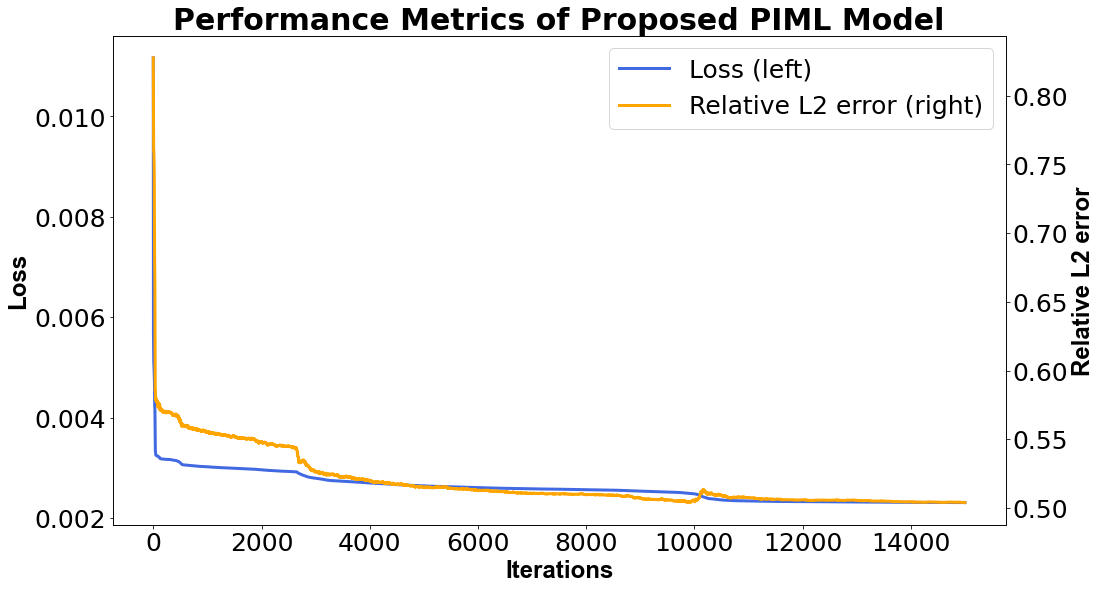

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020923750442760392
MSE =  0.0030741232685868756
RMSE =  0.05544477674756095
L2 relative error = 0.5105785483977637
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

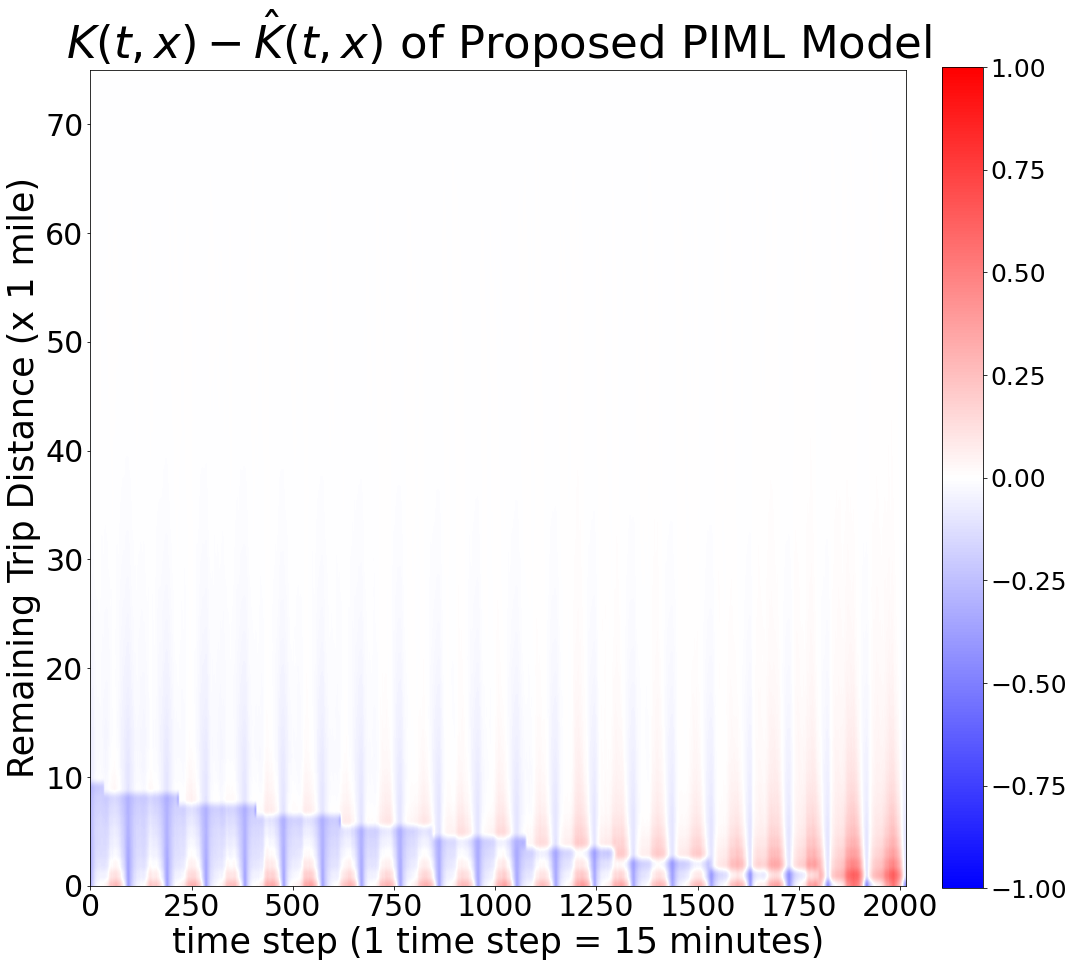

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

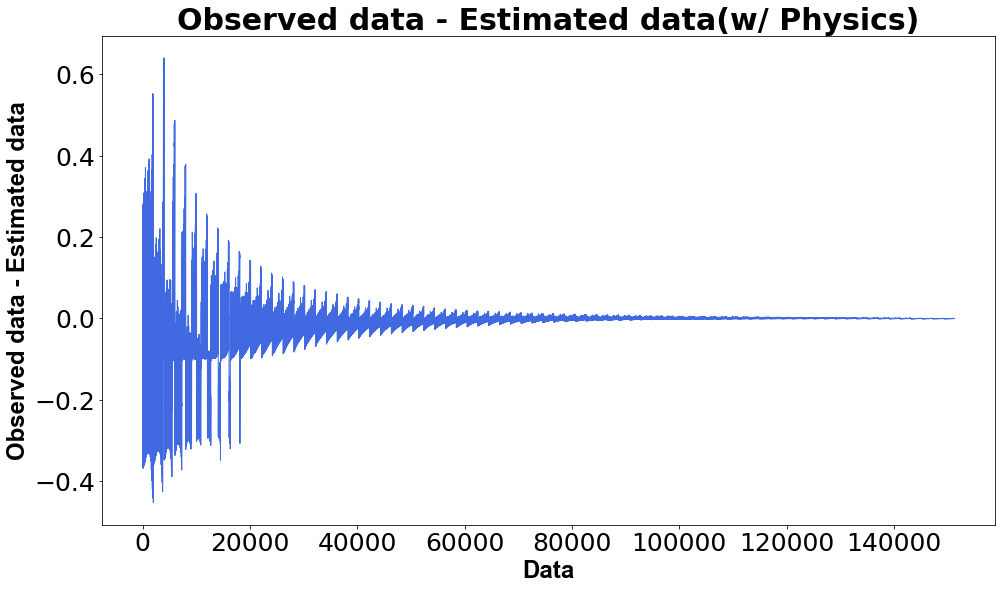

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

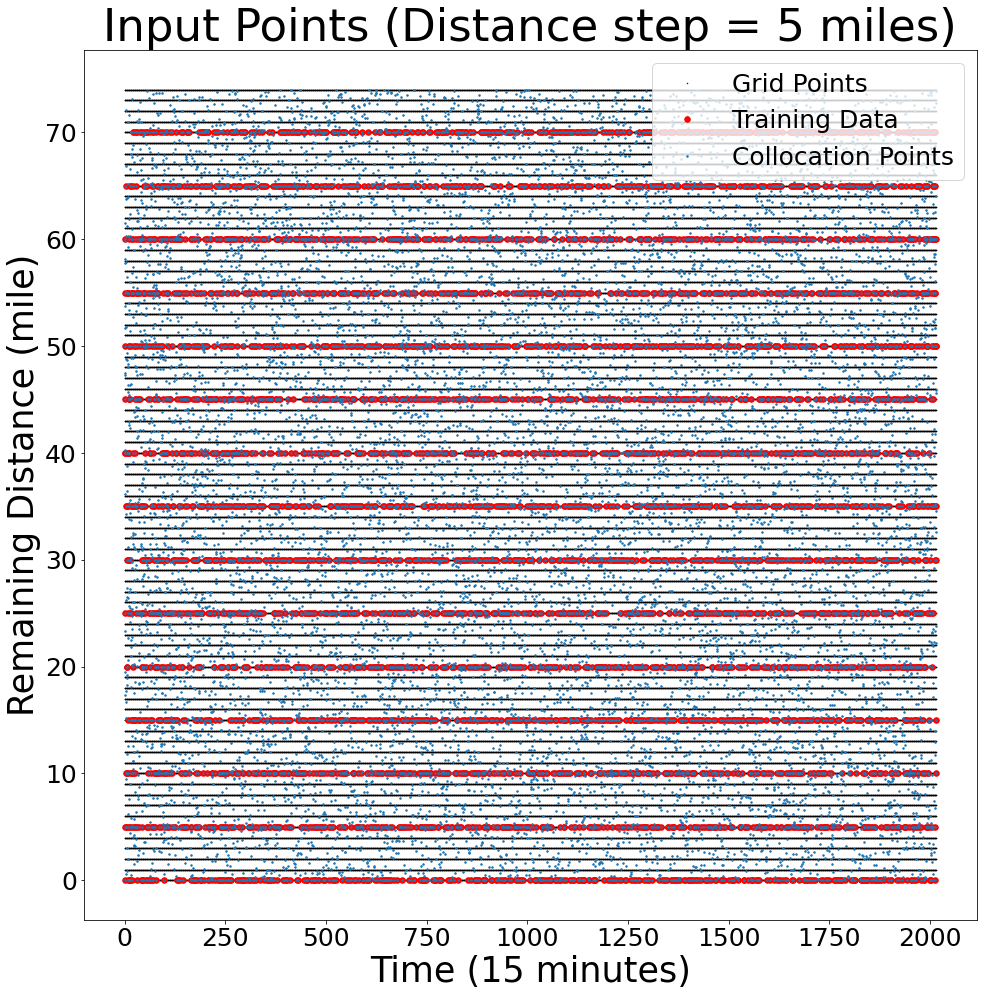

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

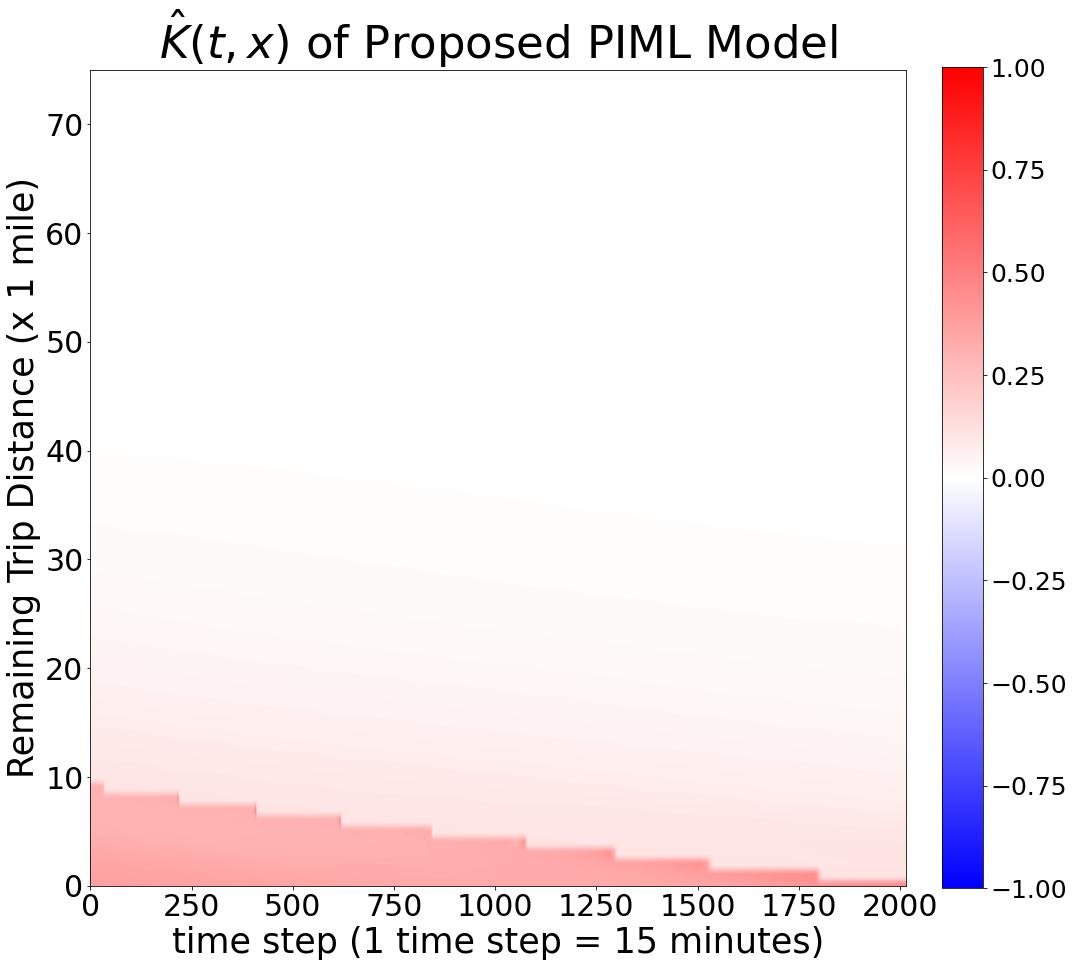

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)